
#GTI-4-GDP - Part 2-of-2
#Part 1 = Google Trends Index (GTI) Pipeline (notebook1)
#(used as input 1-of-16 to THIS notebook2:

#Part 2-of-2, is 16 time-series input to create GDP NowCast Forecast
#Objective: Forecast quarterly U.S. GDP before the official-release.

In [4]:
"""Cell 0A: Automated Economic Data Fetcher and Harmonizer.

This cell automates the multi-day process of fetching, cleaning, and aligning
economic data from disparate sources into a unified quarterly dataset.

TWO FORECAST MODES:
===================

MODE 1: STATIC (Recommended - Maximum Accuracy)
-----------------------------------------------
Use for: Forecasting last COMPLETE quarter before BEA release
Timing: Run ~7 days before BEA advance estimate
Data: ALL data ABOUT last complete quarter (includes lagged releases)
Accuracy: MAXIMUM (matches model training format)

Example Timeline:
  Dec 31, 2024: Q4 ends
  Jan 1-20, 2025: Economic reports release (Dec data)
  Jan 21, 2025: YOU run static mode forecast for Q4
  Jan 28, 2025: BEA releases Q4 GDP
  Your advantage: 7-day head start, same data quality

Why Static is Most Accurate:
  ✓ Model trained on COMPLETE quarterly data (all 90 days)
  ✓ Static mode uses COMPLETE quarters (all 90 days)
  ✓ Apples-to-apples comparison = maximum accuracy
  ✓ All 16 time-series complete and aligned

MODE 2: DYNAMIC (Experimental - Real-Time Nowcast)
--------------------------------------------------
Use for: Real-time monitoring of CURRENT quarter
Timing: Run anytime (weekly, daily)
Data: Includes PARTIAL current quarter data
Accuracy: LOWER (incomplete data, format mismatch)

Example Timeline:
  Jan 21, 2025: Mid-Q1 (quarter ends Mar 31)
  YOU run dynamic mode: Forecast Q1 using 21 days of data
  Warning: Using 21-day average instead of 90-day average

Why Dynamic is Less Accurate:
  ⚠ Model trained on 90-day quarterly averages
  ⚠ Dynamic uses partial quarters (e.g., 21-day averages)
  ⚠ Format mismatch reduces prediction accuracy
  ⚠ Some time-series may have incomplete/outdated data

When to Use Dynamic:
  - Weekly GDP trend monitoring
  - Early warning signals
  - Experimental nowcasting
  - Accept lower accuracy for timeliness

CRITICAL METHODOLOGY - STATIC MODE (A2):
========================================

SCENARIO: Forecasting Q4 2024 GDP on January 21, 2025
- Quarter ended: December 31, 2024
- BEA announces: January 28, 2025 (7 days later)
- YOUR ADVANTAGE: 7-day head start

DATA CUTOFF APPROACH:
- Fetches ALL data ABOUT Q4 2024 that is AVAILABLE BY January 21
- Includes December economic reports released in early January
- Example: December unemployment rate (released ~Jan 10) IS included
- Example: Partial January data (incomplete Q1) is NOT included

WHY THIS IS MOST ACCURATE:
- Your model was TRAINED on complete quarterly data (all 90 days)
- Testing must match training format for valid predictions
- Using partial quarter data violates training assumptions
- Complete Q4 data = apples-to-apples comparison

Data Sources:
- BEA API: GDP (primary source)
- FRED API: 10-year yield, gas prices, jobless claims, corporate yields,
  unemployment rate
- Yahoo Finance: VIX volatility index
- User Upload: GTI from Notebook 1

Frequency Harmonization:
- Daily data (yield, VIX, corp bonds) → Quarterly average
- Weekly data (gas, jobless claims) → Quarterly average
- Monthly data (unemployment) → Quarterly average
- Quarterly data (GDP) → Already aligned
- GTI (quarterly) → Merge on date

Output: 5TS_A_NO_LEAK.xlsx (ready for GDP forecasting pipeline)

Author: Alex Osterneck, CLA, MSCS
Organization: ai70000, Ltd.
"""

import io
import subprocess
import sys
import warnings
from datetime import datetime
from typing import Any, Dict, Optional, Tuple

import ipywidgets as widgets
import numpy as np
import pandas as pd
import requests
from IPython.display import clear_output, display

warnings.filterwarnings('ignore')


# Configuration constants.
START_DATE = '2004-01-01'
QUARTERLY_FREQ = 'QS'  # Quarter start frequency.
FRED_BASE_URL = 'https://fred.stlouisfed.org/graph/fredgraph.csv'


# Module-level variables.
gti_data: Optional[pd.DataFrame] = None
economic_data: Optional[pd.DataFrame] = None
forecast_mode: str = 'static'  # 'static' or 'dynamic'


def install_dependencies() -> None:
    """Install required packages for data fetching.

    Checks if yfinance and pandas-datareader are installed.
    If not, installs them via pip.
    """
    try:
        # Attempt to import required packages.
        # If already installed, these imports will succeed silently.
        import yfinance
        import pandas_datareader
    except ImportError:
        # One or both packages missing - install them.
        print("Installing required packages (yfinance, pandas-datareader)...")

        # Use subprocess to call pip install.
        # -m pip: Ensures we use pip from current Python environment.
        # install -q: Quiet mode (minimal output).
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", "-q",
            "yfinance", "pandas-datareader"
        ])

        print("Installation complete.")


def fetch_gdp_from_bea() -> Optional[pd.DataFrame]:
    """Fetch GDP directly from BEA API.

    Returns:
        DataFrame with quarterly GDP data, or None if fetch fails.
    """
    try:
        url = "https://apps.bea.gov/api/data"

        params = {
            'UserID': 'DEMO_KEY',
            'method': 'GetData',
            'datasetname': 'NIPA',
            'TableName': 'T10101',
            'Frequency': 'Q',
            'Year': 'ALL',
            'ResultFormat': 'json'
        }

        response = requests.get(url, params=params, timeout=30)
        data = response.json()

        if 'BEAAPI' in data and 'Results' in data['BEAAPI']:
            observations = data['BEAAPI']['Results']['Data']

            records = []
            for obs in observations:
                if obs.get('LineNumber') == '1':
                    period = obs.get('TimePeriod', '')
                    value = obs.get('DataValue', '')

                    if period and value and value != '...':
                        year = int(period[:4])
                        q = int(period[-1])
                        month = (q - 1) * 3 + 1
                        date = pd.Timestamp(year, month, 1)

                        gdp = float(value.replace(',', ''))
                        records.append({'date': date, 'GDP': gdp})

            if records:
                df = pd.DataFrame(records).set_index('date')
                return df[df.index >= START_DATE]

        return None

    except Exception:
        return None


def fetch_fred_series(
    series_id: str,
    start_date: str = START_DATE
) -> Optional[pd.DataFrame]:
    """Fetch time series data from FRED.

    Uses direct CSV download (no API key required).
    Falls back to pandas-datareader if CSV method fails.
    Handles multiple possible date column names from FRED.

    Args:
        series_id: FRED series identifier (e.g., 'DGS10').
        start_date: Start date in YYYY-MM-DD format.

    Returns:
        DataFrame with date index and values, or None if fetch fails.
    """
    # METHOD 1: Try direct CSV download first.
    try:
        # Construct FRED CSV download URL.
        # Format: base_url?id=SERIES&cosd=START_DATE
        # No end date - let FRED return all available data
        url = f"{FRED_BASE_URL}?id={series_id}&cosd={start_date}"

        # Download CSV directly from FRED without parsing dates first.
        # This avoids errors if date column has unexpected name.
        df = pd.read_csv(url)

        # Detect date column name (FRED sometimes uses different names).
        # Common variations: DATE, date, observation_date, Date
        date_col = None
        for possible_name in ['DATE', 'date', 'observation_date', 'Date']:
            if possible_name in df.columns:
                date_col = possible_name
                break

        # If no date column found, check first column.
        if date_col is None:
            # Assume first column is the date.
            date_col = df.columns[0]

        # Convert date column to datetime.
        df[date_col] = pd.to_datetime(df[date_col])

        # Set date as index.
        df = df.set_index(date_col)

        # Get value column (should be second column or series_id).
        value_col = None
        for col in df.columns:
            if col != date_col:
                value_col = col
                break

        # If value column not found, use first remaining column.
        if value_col is None and len(df.columns) > 0:
            value_col = df.columns[0]

        # Extract just the value column.
        if value_col is not None:
            df = df[[value_col]]
            df.columns = [series_id]
        else:
            # Malformed response - try fallback method.
            raise ValueError("No value column found in CSV response")

        # Replace FRED's missing value indicator '.' with NaN.
        # FRED uses '.' to denote missing/unavailable data points.
        df = df.replace('.', np.nan)

        # Convert all values to float type.
        # Some FRED series may come as strings with '.' values.
        df = df.astype(float)

        return df

    except Exception as csv_error:
        # METHOD 2: Fall back to pandas_datareader.
        try:
            from pandas_datareader import data as pdr

            # No end date - let pandas_datareader get all available data
            df = pdr.DataReader(series_id, 'fred', start_date)

            # Ensure column is named with series_id.
            if len(df.columns) == 1 and df.columns[0] != series_id:
                df.columns = [series_id]

            return df

        except Exception as pdr_error:
            # Both methods failed - log and return None.
            print(f"Warning: Could not fetch {series_id}")
            print(f"  CSV method error: {csv_error}")
            print(f"  DataReader error: {pdr_error}")
            return None


def fetch_vix_data(start_date: str = START_DATE) -> Optional[pd.DataFrame]:
    """Fetch VIX volatility index from Yahoo Finance.

    Args:
        start_date: Start date in YYYY-MM-DD format.

    Returns:
        DataFrame with date index and VIX closing prices, or None if fails.
    """
    try:
        # Import yfinance library for Yahoo Finance API access.
        import yfinance as yf

        # Download VIX (^VIX ticker symbol) historical data.
        # progress=False: Suppress download progress bar.
        # No end date - let yfinance get all available data through today
        vix = yf.download('^VIX', start=start_date, progress=False)

        # Check if download returned empty dataframe.
        if vix is None or vix.empty:
            return None

        # Handle multi-index columns from yfinance.
        if isinstance(vix.columns, pd.MultiIndex):
            vix.columns = vix.columns.droplevel(1)

        # Extract closing price column only.
        # VIX dataframe includes: Open, High, Low, Close, Volume, Adj Close.
        # We use Close for end-of-day VIX level.
        if 'Close' in vix.columns:
            df = pd.DataFrame({'VIX': vix['Close']})
        elif 'Adj Close' in vix.columns:
            df = pd.DataFrame({'VIX': vix['Adj Close']})
        else:
            # Unknown column structure.
            return None

        return df

    except Exception as error:
        # Log fetch failure and return None.
        print(f"Warning: Could not fetch VIX data: {error}")
        return None


def resample_to_quarterly(
    data: pd.DataFrame,
    method: str = 'mean'
) -> pd.DataFrame:
    """Resample time series data to quarterly frequency.

    CRITICAL: Uses forward-fill before aggregation to ensure complete
    quarterly values that match training data format.

    Why forward-fill?
    - Daily/weekly data has gaps (weekends, holidays, reporting delays)
    - Without forward-fill: gaps become NaN, quarterly avg becomes NaN
    - With forward-fill: gaps use last known value (realistic assumption)
    - Result: Complete quarterly average over all 90 days

    Example (10-year yield):
      Jan 1 (Mon): 4.05
      Jan 2 (Tue): Holiday, no data
      Jan 3 (Wed): 4.07

      Without forward-fill: Q1 avg includes NaN → fails
      With forward-fill: Jan 2 = 4.05 → Q1 avg = (4.05+4.05+4.07)/3

    This matches how financial markets work: rates don't disappear on
    weekends, they just aren't updated. Forward-fill reflects reality.

    A2 METHODOLOGY:
    - Fetches all available data (includes lagged monthly releases)
    - Forward-fills gaps to create complete time series
    - Aggregates to quarterly (mean/last/sum)
    - Result: Complete quarterly data matching training format

    Args:
        data: DataFrame with datetime index and numeric columns.
        method: Aggregation method ('mean', 'last', 'sum').

    Returns:
        DataFrame resampled to quarterly frequency (QS).
    """
    # Forward fill missing values before aggregation.
    # This is ESSENTIAL for A2 methodology - ensures complete quarters.
    data_filled = data.fillna(method='ffill')

    # Resample to quarter start.
    if method == 'mean':
        quarterly = data_filled.resample(QUARTERLY_FREQ).mean()
    elif method == 'last':
        quarterly = data_filled.resample(QUARTERLY_FREQ).last()
    elif method == 'sum':
        quarterly = data_filled.resample(QUARTERLY_FREQ).sum()
    else:
        raise ValueError(f"Unknown aggregation method: {method}")

    return quarterly


def align_to_common_dates(
    dataframes: Dict[str, pd.DataFrame]
) -> pd.DataFrame:
    """Align multiple quarterly dataframes to common date index.

    Takes intersection of dates across all series to ensure complete
    data availability for all features. This prevents downstream
    errors from missing values in any indicator.

    Args:
        dataframes: Dictionary mapping column names to DataFrames.

    Returns:
        Single DataFrame with all series aligned to common dates.
    """
    # Create empty dataframe to combine all series.
    combined = pd.DataFrame()

    # Iterate through each dataframe and add to combined.
    for name, df in dataframes.items():
        # Validate dataframe is not None and not empty.
        if df is not None and not df.empty:
            # Extract first column (series values) and add to combined.
            # Use column name from dictionary key for clarity.
            combined[name] = df.iloc[:, 0]

    # Drop any rows with missing values (NaN).
    # This takes the intersection of dates where ALL series have data.
    # Result: Only complete quarters with all 7 indicators present.
    aligned = combined.dropna()

    return aligned


def fetch_all_economic_indicators() -> Optional[pd.DataFrame]:
    """Fetch and harmonize all economic indicators.

    Implements mode-specific data filtering:

    STATIC MODE (forecast_mode='static'):
    - Fetches ALL data ABOUT last complete quarter
    - Filters out current incomplete quarter (7-day cutoff)
    - Includes lagged releases (e.g., Dec unemployment in early Jan)
    - Result: Complete quarterly data matching training format
    - Maximum accuracy for BEA comparison

    DYNAMIC MODE (forecast_mode='dynamic'):
    - Fetches ALL available data including current partial quarter
    - Includes incomplete current quarter for nowcasting
    - Warning: Partial quarters reduce accuracy
    - Result: Real-time trend monitoring, not precision forecast

    FRED automatically provides latest available data for each series,
    which naturally implements the complete data approach.

    Retrieves data from FRED and Yahoo Finance, resamples to quarterly
    frequency, and aligns to common date index.

    Returns:
        DataFrame with 7 economic indicators at quarterly frequency,
        or None if critical data unavailable.
    """
    # Declare global variable access FIRST (before any usage).
    global forecast_mode

    # Display mode-specific header messages.
    print("=" * 70)

    if forecast_mode == 'static':
        print("STATIC MODE: Fetching Complete Quarterly Data")
        print("=" * 70)
        print("Fetching ALL data about last complete quarter...")
        print("Includes lagged releases for maximum accuracy.")
    else:
        print("DYNAMIC MODE: Fetching Latest Available Data")
        print("=" * 70)
        print("Fetching all available data including current quarter...")
        print("WARNING: Current quarter may be incomplete.")

    print("")

    # Define FRED series identifiers and descriptions.
    fred_series = {
        'DGS10': '10-Year Treasury Yield',
        'GASREGW': 'Regular Gas Price',
        'ICSA': 'Initial Jobless Claims',
        'BAA': 'Corporate Bond Yield (BAA)',
        'UNRATE': 'Unemployment Rate'
    }

    # Fetch FRED data series by series.
    # Dictionary to store fetched dataframes.
    fred_data = {}

    for series_id, description in fred_series.items():
        print(f"Fetching {description} ({series_id})...", end=' ')
        data = fetch_fred_series(series_id)

        if data is not None:
            print(f"Success ({len(data)} records)")
            fred_data[series_id] = data
        else:
            print("Failed")
            # Critical data missing - abort.
            return None

    # Fetch GDP from BEA (primary source), fall back to FRED if needed.
    print("Fetching GDP from BEA (primary source)...", end=' ')
    gdp_data = fetch_gdp_from_bea()

    if gdp_data is None:
        # Fall back to FRED
        print("Failed - trying FRED...", end=' ')
        gdp_data = fetch_fred_series('GDP')

    if gdp_data is not None:
        print(f"Success ({len(gdp_data)} records)")
        fred_data['GDP'] = gdp_data
    else:
        print("Failed")
        return None

    # Fetch VIX data from Yahoo Finance.
    print("Fetching VIX from Yahoo Finance...", end=' ')
    vix_data = fetch_vix_data()

    if vix_data is not None:
        print(f"Success ({len(vix_data)} records)")
    else:
        print("Failed")
        # VIX is critical - abort if unavailable.
        return None

    print("")
    print("Resampling all series to quarterly frequency...")

    # Resample each series from native frequency to quarterly.
    # Dictionary to store quarterly-resampled dataframes.
    quarterly_data = {}

    # Daily, weekly, and monthly series → quarterly average.
    # Use mean aggregation to get representative quarterly value.
    for series_id in ['DGS10', 'GASREGW', 'ICSA', 'BAA', 'UNRATE']:
        quarterly_data[series_id] = resample_to_quarterly(
            fred_data[series_id], method='mean'
        )

    # VIX volatility index → quarterly average.
    quarterly_data['VIX'] = resample_to_quarterly(vix_data, method='mean')

    # GDP is already quarterly - just align to quarter start dates.
    # Use 'last' to take the quarterly value as-is.
    quarterly_data['GDP'] = resample_to_quarterly(
        fred_data['GDP'], method='last'
    )

    # DIAGNOSTIC: Show what GDP data was actually provided.
    print("")
    print("DIAGNOSTIC - GDP Data Range:")
    if quarterly_data['GDP'] is not None and not quarterly_data['GDP'].empty:
        gdp_df = quarterly_data['GDP']
        print(f"  Start: {gdp_df.index[0].date()}")
        print(f"  End: {gdp_df.index[-1].date()}")
        print(f"  Quarters: {len(gdp_df)}")
        print(f"  Last value: {gdp_df.iloc[-1, 0]:.2f}")
    else:
        print("  ERROR: No GDP data received")
    print("")

    print("Aligning all series to common dates...")

    # Combine all quarterly data.
    # Both modes: Start by combining all data (allow NaN for now).
    combined = pd.DataFrame()
    for name, df in quarterly_data.items():
        if df is not None and not df.empty:
            combined[name] = df.iloc[:, 0]

    # MODE-SPECIFIC FILTERING.
    if forecast_mode == 'static':
        # STATIC MODE: Require complete data for forecasting.
        # Drop rows where GDP is missing (can't forecast without target).
        # But show most recent complete GDP data available.
        aligned = combined.dropna(subset=['GDP'])

        print("")
        print("STATIC MODE: Using quarters with complete GDP data")
        if len(aligned) > 0:
            print(f"Latest GDP data through: {aligned.index[-1].date()}")
            print(f"Total quarters: {len(aligned)}")
            print(f"Last GDP value: {aligned['GDP'].iloc[-1]:.2f}")
            print("")
            print("Last 3 quarters of data:")
            display_df = aligned.tail(3).round(2)
            print(display_df.to_string())
    else:
        # DYNAMIC MODE: Keep all data, even if GDP missing.
        aligned = combined
        print("")
        print("DYNAMIC MODE: Including all available data")
        if len(aligned) > 0:
            print(f"Data through: {aligned.index[-1].date()}")
            print(f"Total quarters: {len(aligned)}")
            # Check for missing GDP.
            gdp_missing = aligned['GDP'].isna().sum()
            if gdp_missing > 0:
                print(f"⚠ {gdp_missing} quarters with missing GDP")
            print("")
            print("Last 3 quarters of data:")
            display_df = aligned.tail(3).round(2)
            print(display_df.to_string())

    # Rename columns from FRED codes to descriptive names.
    # This matches the expected format for downstream processing.
    aligned = aligned.rename(columns={
        'DGS10': 'yield_10yr',
        'GASREGW': 'gas_price',
        'ICSA': 'jobless_claims_quarterly_avg',
        'VIX': 'vix_quarterly_avg',
        'BAA': 'CorpYield_QtrAvg',
        'UNRATE': 'UNRATE_QtrAvg',
        'GDP': 'gdp'
    })

    # Calculate GDP percent change (the target variable).
    # Formula: ((GDP[t] - GDP[t-1]) / GDP[t-1]) * 100
    aligned['gdp_pct_change_target'] = aligned['gdp'].pct_change() * 100

    # Display summary statistics.
    print(f"Success: {len(aligned)} quarterly periods aligned")
    print(f"Date range: {aligned.index[0].date()} to {aligned.index[-1].date()}")
    print("")

    return aligned


def create_mode_selector() -> None:
    """Create mode selector for static vs dynamic forecasting."""
    global forecast_mode

    # Create buttons instead of radio buttons for cleaner layout.
    btn_static = widgets.Button(
        description='STATIC Mode',
        button_style='info',
        tooltip='Maximum accuracy - recommended',
        layout=widgets.Layout(width='200px')
    )

    btn_dynamic = widgets.Button(
        description='DYNAMIC Mode',
        button_style='',
        tooltip='Real-time nowcast - experimental',
        layout=widgets.Layout(width='200px')
    )

    # Info display area.
    info_output = widgets.Output()

    def show_static_info(b: widgets.Button) -> None:
        """Display static mode information.

        Args:
            b: Button widget that triggered event.
        """
        global forecast_mode
        forecast_mode = 'static'

        # Update button styles.
        btn_static.button_style = 'info'
        btn_dynamic.button_style = ''

        with info_output:
            clear_output()
            print("STATIC MODE SELECTED")
            print("-" * 70)
            print("Best for: Forecasting last COMPLETE quarter")
            print("Run timing: ~7 days before BEA advance estimate")
            print("Data used: ALL data about last complete quarter")
            print("Accuracy: MAXIMUM (matches training data format)")
            print("")
            print("Example:")
            print("  Today: January 21, 2025")
            print("  Forecast: Q4 2024 GDP (quarter ended Dec 31)")
            print("  Data: Complete Q4 through all lagged releases")
            print("  BEA: Releases Jan 28 (you're 7 days ahead)")
            print("")
            print("✓ All 16 time-series complete")
            print("✓ Full 90-day quarterly averages")
            print("✓ Matches model training format")

    def show_dynamic_info(b: widgets.Button) -> None:
        """Display dynamic mode information.

        Args:
            b: Button widget that triggered event.
        """
        global forecast_mode
        forecast_mode = 'dynamic'

        # Update button styles.
        btn_static.button_style = ''
        btn_dynamic.button_style = 'info'

        with info_output:
            clear_output()
            print("DYNAMIC MODE SELECTED")
            print("-" * 70)
            print("Best for: Real-time 'nowcast' of CURRENT quarter")
            print("Run timing: Anytime (weekly, daily)")
            print("Data used: Includes PARTIAL current quarter data")
            print("Accuracy: LOWER (incomplete data, format mismatch)")
            print("")
            print("Example:")
            print("  Today: January 21, 2025 (mid-Q1)")
            print("  Forecast: Q1 2025 GDP (quarter ends Mar 31)")
            print("  Data: Only 21 days of Q1 available so far")
            print("  Warning: Using 21-day avg instead of 90-day avg")
            print("")
            print("⚠ Some time-series may be incomplete")
            print("⚠ Partial quarter ≠ training data format")
            print("⚠ Lower accuracy, use for trend monitoring only")
            print("")
            print("CAVEAT: Dynamic mode trades accuracy for timeliness")

    # Attach click handlers.
    btn_static.on_click(show_static_info)
    btn_dynamic.on_click(show_dynamic_info)

    # Initialize with static mode selected.
    show_static_info(None)

    # Display interface.
    display(widgets.VBox([
        widgets.HTML(
            "<h4>Step 0: Select Forecast Mode</h4>"
            "<p>Choose between maximum accuracy (static) or "
            "real-time nowcast (dynamic):</p>"
        ),
        widgets.HBox([btn_static, btn_dynamic]),
        widgets.HTML("<hr>"),
        info_output
    ]))


def create_gti_uploader() -> None:
    """Create widget for uploading GTI file from Notebook 1."""
    global gti_data

    # Create upload widget with enhanced styling.
    upload_widget = widgets.FileUpload(
        accept='.xlsx',
        multiple=False,
        description='Select File:',
        button_style='primary',  # Blue button style.
        layout=widgets.Layout(width='400px')
    )

    output = widgets.Output()

    def on_upload(change: Dict[str, Any]) -> None:
        """Handle GTI file upload.

        Args:
            change: Widget change event.
        """
        global gti_data

        with output:
            clear_output()

            if not upload_widget.value:
                print("No file uploaded.")
                return

            try:
                # Extract uploaded file content and metadata.
                uploaded_file = list(upload_widget.value.values())[0]
                file_content = uploaded_file['content']
                file_name = uploaded_file['metadata']['name']

                # Read GTI Excel file from memory.
                gti_df = pd.read_excel(io.BytesIO(file_content))

                # Display file information.
                print(f"Loaded: {file_name}")
                print(f"Shape: {gti_df.shape}")
                print(f"Columns: {list(gti_df.columns)}")

                # Validate required GTI column exists.
                # Accept either 'GTI' or 'GTI_Normalized_0_100'.
                gti_col = None
                if 'GTI_Normalized_0_100' in gti_df.columns:
                    gti_col = 'GTI_Normalized_0_100'
                elif 'GTI' in gti_df.columns:
                    gti_col = 'GTI'
                    # Rename for consistency.
                    gti_df = gti_df.rename(columns={'GTI': 'GTI_Normalized_0_100'})

                if gti_col is None:
                    print(
                        "\nError: File must contain either "
                        "'GTI' or 'GTI_Normalized_0_100' column"
                    )
                    gti_data = None
                    return

                # Convert date column to datetime if present.
                if 'date' in gti_df.columns:
                    gti_df['date'] = pd.to_datetime(gti_df['date'])
                    gti_df = gti_df.set_index('date')

                # Store GTI data globally.
                gti_data = gti_df

                # Display success message and preview.
                print(f"\nSuccess: GTI data loaded")
                print(f"Periods: {len(gti_data)}")
                print(f"\nFirst few rows:")
                print(gti_data.round(2).head())

            except Exception as error:
                print(f"Error loading GTI file: {error}")
                gti_data = None

    # Attach upload event handler.
    upload_widget.observe(on_upload, names='value')

    # Display upload interface.
    display(widgets.VBox([
        widgets.HTML(
            "<h4>Step 1: Upload GTI from Notebook 1</h4>"
            "<p><b>Upload the GTI_Quarterly_PCA.xlsx file generated by "
            "Notebook 1.</b></p>"
        ),
        upload_widget,
        output
    ]))


def create_fetch_button() -> None:
    """Create button to fetch economic data."""
    global economic_data

    button = widgets.Button(
        description='Fetch Economic Data',
        button_style='primary',
        icon='download',
        layout=widgets.Layout(width='250px')
    )

    output = widgets.Output()

    def on_click(b: widgets.Button) -> None:
        """Handle fetch button click.

        Args:
            b: Button widget.
        """
        global economic_data

        with output:
            clear_output()

            print("=" * 70)
            print("FETCHING ECONOMIC DATA")
            print("=" * 70)
            print("")

            economic_data = fetch_all_economic_indicators()

            if economic_data is not None:
                print("=" * 70)
                print("DATA FETCH COMPLETE")
                print("=" * 70)
                print(f"\nColumns: {list(economic_data.columns)}")
                print(f"\nSample data:")
                print(economic_data.round(2).head())
                print(f"\nReady to merge with GTI.")
            else:
                print("\nError: Failed to fetch economic data.")

    button.on_click(on_click)

    display(widgets.VBox([
        widgets.HTML("<br><h4>Step 2: Fetch Economic Indicators</h4>"),
        button,
        output
    ]))


def create_merge_button() -> None:
    """Create button to merge data and export."""
    button = widgets.Button(
        description='Export: XLSX#1 or XLSX#2',
        button_style='success',
        icon='check',
        layout=widgets.Layout(width='250px')
    )

    output = widgets.Output()

    def on_click(b: widgets.Button) -> None:
        """Handle merge button click.

        Args:
            b: Button widget.
        """
        global gti_data, economic_data, forecast_mode

        with output:
            clear_output()

            print("=" * 70)
            print("MERGING DATA AND EXPORTING")
            print("=" * 70)
            print("")

            if gti_data is None:
                print("Error: Please upload GTI file first (Step 1).")
                return

            if economic_data is None:
                print("Error: Please fetch economic data first (Step 2).")
                return

            try:
                print("Merging GTI with economic indicators...")

                # Merge GTI with economic data on date index.
                merged = economic_data.copy()
                merged['GTI_Normalized_0_100'] = gti_data['GTI_Normalized_0_100']

                # MODE-SPECIFIC NaN HANDLING.

                if forecast_mode == 'static':
                    # STATIC MODE: Drop rows with ANY missing data.
                    merged = merged.dropna()
                    print("Static mode: Dropped incomplete rows")
                else:
                    # DYNAMIC MODE: Keep rows even if GDP missing.
                    # Only drop if GTI is missing (critical).
                    merged = merged.dropna(subset=['GTI_Normalized_0_100'])
                    print("Dynamic mode: Kept rows with missing GDP")

                # Display merge results.
                print(f"Merged dataset: {merged.shape}")
                if len(merged) > 0:
                    print(f"Date range: {merged.index[0].date()} to "
                          f"{merged.index[-1].date()}")

                # Reset index to convert date from index to column.
                # This makes date a regular column for Excel export.
                merged = merged.reset_index()

                # Rename index column to 'date'.
                if 'index' in merged.columns:
                    merged = merged.rename(columns={'index': 'date'})
                elif merged.columns[0] != 'date':
                    # First column is the date, rename it.
                    merged = merged.rename(columns={merged.columns[0]: 'date'})

                # Reorder columns to match expected format.
                # This order matches user's original data structure.
                column_order = [
                    'date',                          # Quarter start date
                    'yield_10yr',                    # 10-year Treasury yield
                    'gas_price',                     # Regular gasoline price
                    'jobless_claims_quarterly_avg',  # Initial claims
                    'vix_quarterly_avg',             # Volatility index
                    'CorpYield_QtrAvg',             # Corporate bond yield
                    'UNRATE_QtrAvg',                # Unemployment rate
                    'GTI_Normalized_0_100',         # Google Trends Index
                    'gdp',                          # Gross Domestic Product
                    'gdp_pct_change_target'         # Target variable
                ]

                # Reindex with specified column order.
                merged = merged[column_order]

                # Round all numeric columns to 2 decimal places.
                numeric_cols = merged.select_dtypes(include=['float64', 'int64']).columns
                merged[numeric_cols] = merged[numeric_cols].round(2)

                # Export to Excel file with mode-specific filename.
                if forecast_mode == 'static':
                    output_filename = 'XLSX#1_Economic_Data_Static.xlsx'
                else:
                    output_filename = 'XLSX#2_Economic_Data_Dynamic.xlsx'

                merged.to_excel(output_filename, index=False)

                # Display export success message.
                print(f"\nSuccess: Exported to {output_filename}")
                print(f"Total rows: {len(merged)}")
                print(f"Total columns: {len(merged.columns)}")

                # Display column summary for verification.
                print("\nColumn summary:")
                for i, col in enumerate(merged.columns, 1):
                    print(f"  {i:2d}. {col}")

                # Display first few rows as preview.
                print("\nFirst few rows:")
                print(merged.round(2).head())

                print("\n" + "=" * 70)

                # Display mode-specific completion messages.
                if forecast_mode == 'static':
                    # Static mode: Maximum accuracy messaging.
                    print("STATIC MODE: DATASET READY FOR MAXIMUM ACCURACY")
                    print("=" * 70)
                    print("✓ All quarters complete (90-day averages)")
                    print("✓ Matches model training format")
                    print("✓ Ready for accurate GDP forecasting")
                    print("")
                    print(f"Last quarter: {merged['date'].iloc[-1].date()}")
                    print("Run forecast ~7 days before BEA advance estimate")
                else:
                    # Dynamic mode: Experimental nowcast messaging.
                    print("DYNAMIC MODE: DATASET READY (EXPERIMENTAL)")
                    print("=" * 70)
                    print("⚠ May include partial current quarter")
                    print("⚠ Lower accuracy than static mode")
                    print("⚠ Use for trend monitoring, not precision")
                    print("")
                    print(f"Last quarter: {merged['date'].iloc[-1].date()}")
                    print("Consider switching to STATIC mode for BEA comparison")

                print("")
                print(f"Proceed to Cell 0 to upload this file.")

                # Attempt download in Google Colab environment.
                try:
                    from google.colab import files
                    files.download(output_filename)
                    print(f"\nDownload initiated: {output_filename}")
                except Exception:
                    # Not in Colab or download failed.
                    # File still saved in filesystem.
                    print(f"\nFile saved: {output_filename}")

            except Exception as error:
                print(f"Error during merge: {error}")
                import traceback
                traceback.print_exc()

    button.on_click(on_click)

    display(widgets.VBox([
        widgets.HTML("<br><h4>Step 3: Merge Data and Export</h4>"),
        button,
        output
    ]))


# Install dependencies and display interface.
install_dependencies()

print("=" * 70)
print("AUTOMATED ECONOMIC DATA FETCHER")
print("=" * 70)
print("")
print("This cell automates the multi-day data scrubbing process:")
print("  1. Fetch indicators from FRED and Yahoo Finance")
print("  2. Resample daily/weekly/monthly to quarterly")
print("  3. Align all series to common dates")
print("  4. Merge with GTI from Notebook 1")
print("  5. Export: 5TS_A_NO_LEAK.xlsx")
print("")
print("TWO FORECAST MODES AVAILABLE:")
print("-" * 70)
print("STATIC (Recommended): Maximum accuracy, ~7-day BEA head start")
print("DYNAMIC (Experimental): Anytime nowcast, lower accuracy")
print("")
print("Follow the 4 steps below:")
print("=" * 70)

create_mode_selector()
create_gti_uploader()
create_fetch_button()
create_merge_button()

print("")
print("Note: Requires internet connection.")
print("Data sources: BEA (GDP), FRED (Federal Reserve), and Yahoo Finance.")

AUTOMATED ECONOMIC DATA FETCHER

This cell automates the multi-day data scrubbing process:
  1. Fetch indicators from FRED and Yahoo Finance
  2. Resample daily/weekly/monthly to quarterly
  3. Align all series to common dates
  4. Merge with GTI from Notebook 1
  5. Export: 5TS_A_NO_LEAK.xlsx

TWO FORECAST MODES AVAILABLE:
----------------------------------------------------------------------
STATIC (Recommended): Maximum accuracy, ~7-day BEA head start
DYNAMIC (Experimental): Anytime nowcast, lower accuracy

Follow the 4 steps below:



Note: Requires internet connection.
Data sources: BEA (GDP), FRED (Federal Reserve), and Yahoo Finance.


RAW DATA ANALYSIS

FEATURE CORRELATION ANALYSIS

Rank  Feature                            Correlation    
--------------------------------------------------------
1     jobless_claims_quarterly_avg               0.4959
2     vix_quarterly_avg                          0.3474
3     UNRATE_QtrAvg                              0.2826
4     CorpYield_QtrAvg                           0.2522
5     gas_price                                  0.1523
6     GTI_Normalized_0_100                       0.1135
7     yield_10yr                                 0.0173


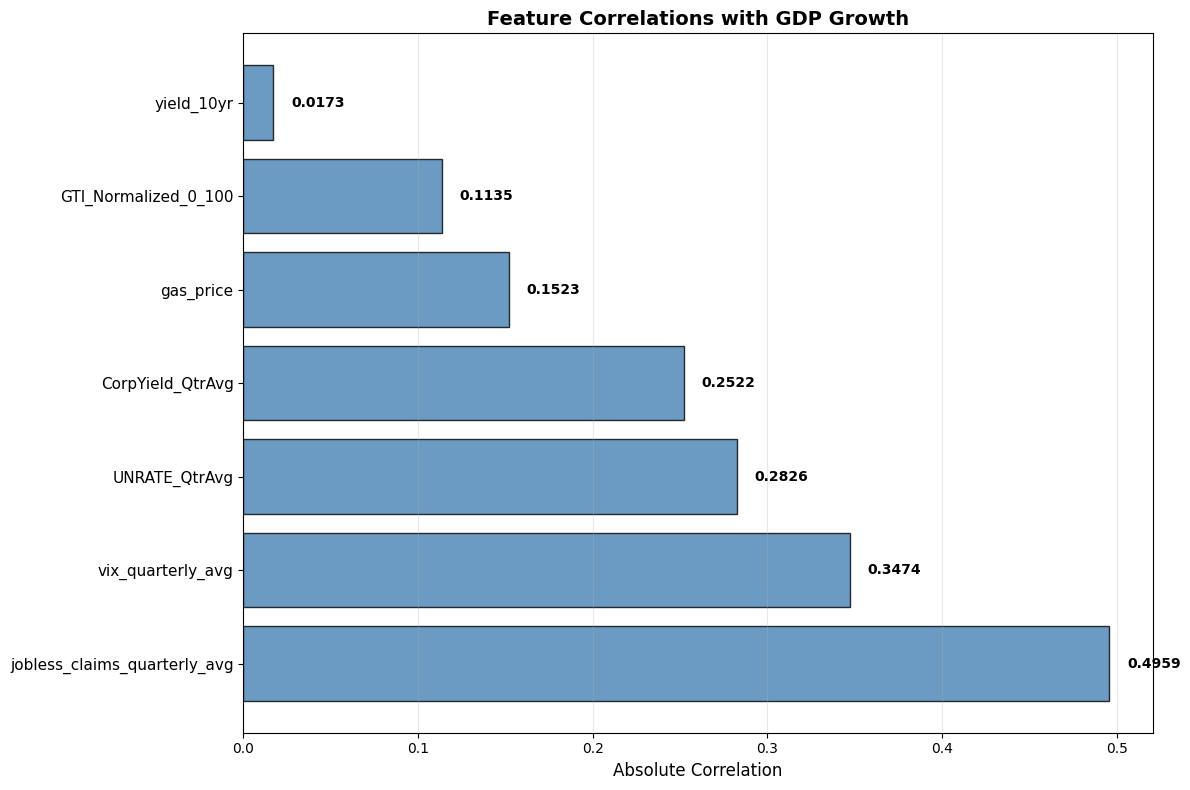


GDP GROWTH TIME SERIES


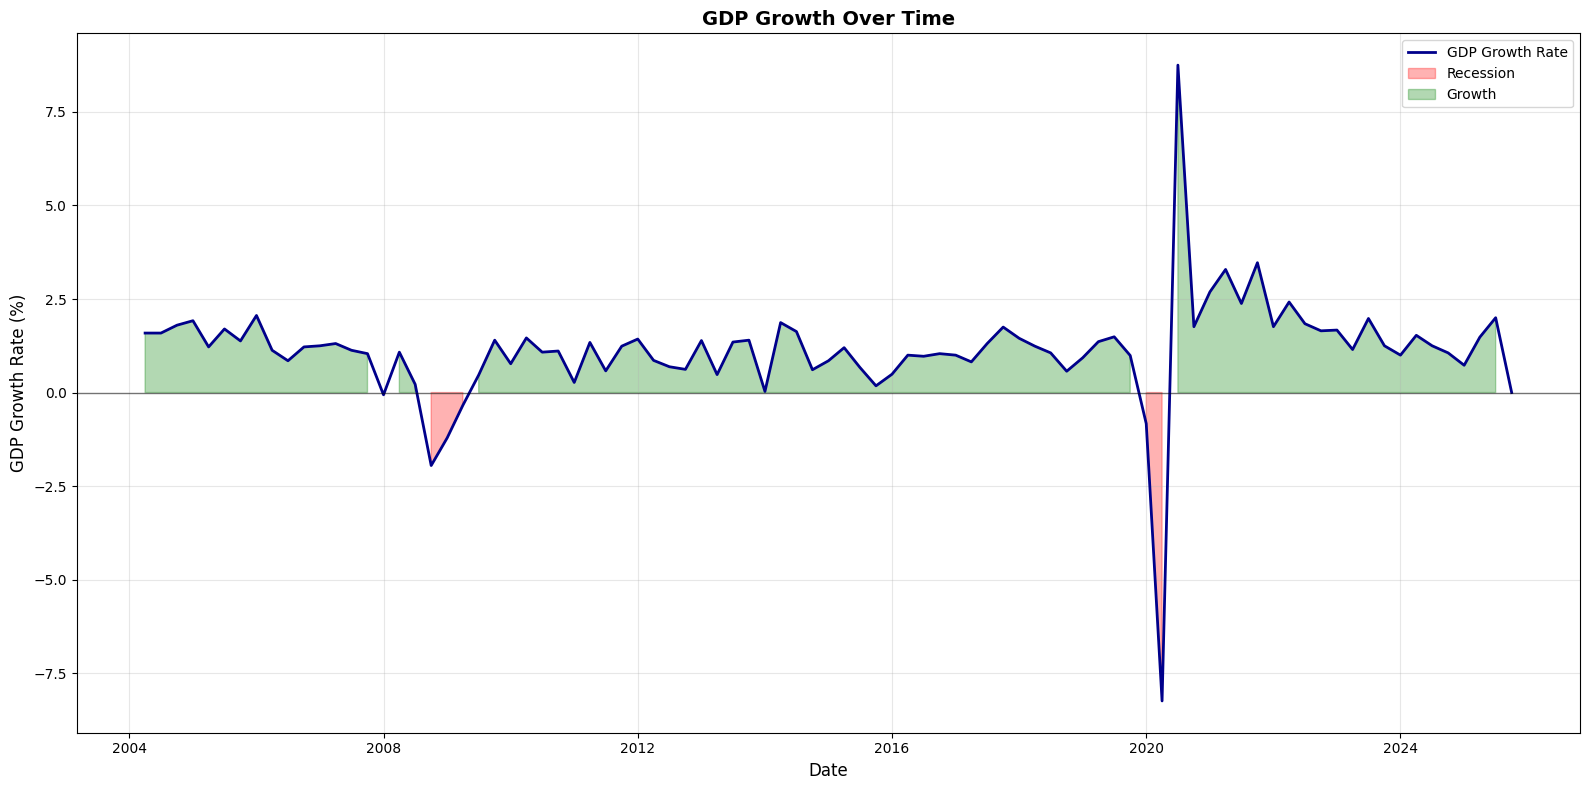


Quarters: 87
Mean: 1.12%
Std: 1.53%
Min: -8.24%
Max: 8.75%

Recession quarters: 6
Recession %: 6.9%

ANALYSIS COMPLETE


In [ ]:
# =============================================================================
# RAW DATA ANALYSIS - CODE BLOCK 2
# =============================================================================
"""Analyze raw data from code block 1 output xlsx file."""

from typing import Optional, Dict, Any
import io
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

warnings.filterwarnings('ignore')


# Try to access df from previous run, otherwise initialize to None
try:
    if df is not None:
        pass  # df already exists from previous upload
except NameError:
    df = None  # First time running this cell


def create_data_uploader() -> None:
    """Create widget for uploading xlsx from code block 1."""
    global df

    upload_widget = widgets.FileUpload(
        accept='.xlsx',
        multiple=False,
        description='Select File:',
        button_style='primary',
        layout=widgets.Layout(width='400px')
    )

    output = widgets.Output()

    def on_upload(change: Dict[str, Any]) -> None:
        """Handle file upload.

        Args:
            change: Widget change event.
        """
        global df

        with output:
            clear_output()

            if not upload_widget.value:
                print('No file uploaded.')
                return

            try:
                # Extract uploaded file content
                uploaded_file = list(upload_widget.value.values())[0]
                file_content = uploaded_file['content']
                file_name = uploaded_file['metadata']['name']

                # Read Excel file
                df = pd.read_excel(io.BytesIO(file_content))

                print(f'Loaded: {file_name}')
                print(f'Shape: {df.shape}')
                print(f'Columns: {list(df.columns)}')

                print('\nSuccess: Data loaded')
                print('\nRe-run this cell to see visualizations')

            except Exception as error:
                print(f'Error loading file: {error}')
                df = None

    upload_widget.observe(on_upload, names='value')

    display(widgets.VBox([
        widgets.HTML(
            '<h4>Upload Code Block 1 Output</h4>'
            '<p>Upload the xlsx file downloaded from code block 1:</p>'
        ),
        upload_widget,
        output
    ]))


def analyze_correlations() -> Optional[bool]:
    """Analyze feature correlations with GDP target.

    Returns:
        True if successful, None if error.
    """
    global df

    if df is None:
        return None

    print('=' * 80)
    print('FEATURE CORRELATION ANALYSIS')
    print('=' * 80)

    # Seven input features
    features = [
        'yield_10yr', 'gas_price', 'jobless_claims_quarterly_avg',
        'vix_quarterly_avg', 'CorpYield_QtrAvg', 'UNRATE_QtrAvg',
        'GTI_Normalized_0_100'
    ]

    # Calculate correlations
    corrs = {}
    for feat in features:
        if feat in df.columns:
            valid = df[[feat, 'gdp_pct_change_target']].dropna()
            if len(valid) > 0:
                corrs[feat] = abs(
                    valid[feat].corr(valid['gdp_pct_change_target'])
                )

    # Sort by strength
    sorted_corrs = sorted(corrs.items(), key=lambda x: x[1], reverse=True)

    # Display table
    print(f"\n{'Rank':<6}{'Feature':<35}{'Correlation':<15}")
    print('-' * 56)
    for i, (feat, corr) in enumerate(sorted_corrs, 1):
        print(f'{i:<6}{feat:<35}{corr:>14.4f}')

    # Visualize
    feats, vals = zip(*sorted_corrs)

    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(
        range(len(feats)), vals,
        color='steelblue', alpha=0.8, edgecolor='black'
    )

    ax.set_yticks(range(len(feats)))
    ax.set_yticklabels(feats, fontsize=11)
    ax.set_xlabel('Absolute Correlation', fontsize=12)
    ax.set_title(
        'Feature Correlations with GDP Growth',
        fontsize=14, fontweight='bold'
    )
    ax.grid(True, alpha=0.3, axis='x')

    # Add labels
    for bar, corr in zip(bars, vals):
        ax.text(
            bar.get_width() + 0.01,
            bar.get_y() + bar.get_height() / 2.,
            f'{corr:.4f}',
            ha='left', va='center', fontsize=10, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

    return True


def visualize_gdp_timeseries() -> Optional[bool]:
    """Create GDP time series visualization.

    Returns:
        True if successful, None if error.
    """
    global df

    if df is None:
        return None

    print('\n' + '=' * 80)
    print('GDP GROWTH TIME SERIES')
    print('=' * 80)

    # Extract data
    data = df[['date', 'gdp_pct_change_target']].dropna()
    data['date'] = pd.to_datetime(data['date'])

    # Create plot
    fig, ax = plt.subplots(figsize=(16, 8))

    ax.plot(
        data['date'], data['gdp_pct_change_target'],
        linewidth=2, color='darkblue', label='GDP Growth Rate'
    )

    # Highlight recessions
    recession = data['gdp_pct_change_target'] < 0
    ax.fill_between(
        data['date'], data['gdp_pct_change_target'], 0,
        where=recession, color='red', alpha=0.3, label='Recession'
    )

    # Highlight growth
    growth = data['gdp_pct_change_target'] > 0
    ax.fill_between(
        data['date'], 0, data['gdp_pct_change_target'],
        where=growth, color='green', alpha=0.3, label='Growth'
    )

    ax.axhline(0, color='black', linewidth=1, alpha=0.5)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('GDP Growth Rate (%)', fontsize=12)
    ax.set_title(
        'GDP Growth Over Time',
        fontsize=14, fontweight='bold'
    )
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistics
    print(f"\nQuarters: {len(data)}")
    print(f'Mean: {data["gdp_pct_change_target"].mean():.2f}%')
    print(f'Std: {data["gdp_pct_change_target"].std():.2f}%')
    print(f'Min: {data["gdp_pct_change_target"].min():.2f}%')
    print(f'Max: {data["gdp_pct_change_target"].max():.2f}%')

    rec_count = (data['gdp_pct_change_target'] < 0).sum()
    print(f'\nRecession quarters: {rec_count}')
    print(f'Recession %: {rec_count / len(data) * 100:.1f}%')

    return True


# Main execution
if df is None:
    # Show upload widget
    create_data_uploader()
else:
    # Run analysis
    print('=' * 80)
    print('RAW DATA ANALYSIS')
    print('=' * 80)
    print()

    analyze_correlations()
    visualize_gdp_timeseries()

    print('\n' + '=' * 80)
    print('ANALYSIS COMPLETE')
    print('=' * 80)

In [6]:
# =============================================================================
# ENGINEERED FEATURES GENERATOR WITH EXCEL EXPORT
# =============================================================================
"""Generate engineered features for GDP forecasting.

This module creates 5 engineered features from the 7 raw input features:
1. gdp_volatility: Rolling standard deviation of GDP growth
2. term_spread: 10-year yield minus 2-year approximation
3. credit_spread: Corporate yield minus Treasury yield
4. labor_stress: Jobless claims multiplied by unemployment rate
5. financial_stress: Composite index of market stress

All features use leakage-proof methodology with proper temporal handling.
Exports to Excel with formula documentation and highlighting.
Auto-downloads to user's local machine.
"""

from typing import Optional, Tuple, Dict, Any
import io
import warnings

import numpy as np
import pandas as pd
from openpyxl import Workbook, load_workbook
from openpyxl.comments import Comment
from openpyxl.styles import Font, PatternFill, Alignment
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import base64
import os

warnings.filterwarnings('ignore')


# Check if df exists from previous run BEFORE defining it
try:
    if df is not None:
        pass  # df already exists from previous upload
except NameError:
    df = None  # First time running this cell


def create_data_uploader() -> None:
    """Create widget for uploading xlsx from code block 2.

    Allows user to upload the Excel file output from code block 2.
    Sets global df variable when file is uploaded successfully.
    """
    global df

    upload_widget = widgets.FileUpload(
        accept='.xlsx',
        multiple=False,
        description='Select File:',
        button_style='primary',
        layout=widgets.Layout(width='400px')
    )

    output = widgets.Output()

    def on_upload(change: Dict[str, Any]) -> None:
        """Handle file upload.

        Args:
            change: Widget change event dictionary.
        """
        global df

        with output:
            clear_output()

            if not upload_widget.value:
                print('No file uploaded.')
                return

            try:
                # Extract uploaded file content
                uploaded_file = list(upload_widget.value.values())[0]
                file_content = uploaded_file['content']
                file_name = uploaded_file['metadata']['name']

                # Read Excel file from memory
                df = pd.read_excel(io.BytesIO(file_content))

                print(f'Loaded: {file_name}')
                print(f'Shape: {df.shape}')
                print(f'Columns: {list(df.columns)}')
                print('\nSuccess: Data loaded')
                print('Re-run this cell to generate engineered features')

            except Exception as error:
                print(f'Error loading file: {error}')
                df = None

    upload_widget.observe(on_upload, names='value')

    display(widgets.VBox([
        widgets.HTML(
            '<h4>Upload Code Block 2 Output</h4>'
            '<p>Upload the xlsx file from code block 2:</p>'
        ),
        upload_widget,
        output
    ]))


def generate_engineered_features() -> Tuple[
    Optional[pd.DataFrame], Optional[str]
]:
    """Generate all engineered features with documentation.

    Creates 5 engineered features from raw inputs:
    - gdp_volatility: 4-quarter rolling std of GDP growth (shifted)
    - term_spread: 10yr yield - 2yr approximation
    - credit_spread: Corporate yield - Treasury yield
    - labor_stress: jobless_claims * unemployment / 100
    - financial_stress: Composite stress indicator

    Exports results to Excel with comments and auto-downloads.

    Returns:
        Tuple of (engineered_dataframe, output_filename) if successful,
        (None, None) if error occurred.
    """
    global df

    if df is None:
        print('Error: No data loaded.')
        return None, None

    print('=' * 80)
    print('GENERATING ENGINEERED FEATURES FOR GDP FORECASTING')
    print('=' * 80)

    try:
        # Create working copy of dataframe
        df_engineered = df.copy()

        # Display base data columns
        print('\nBASE DATA COLUMNS (B-H):')
        base_columns = [
            'yield_10yr', 'gas_price', 'jobless_claims_quarterly_avg',
            'vix_quarterly_avg', 'CorpYield_QtrAvg', 'UNRATE_QtrAvg',
            'GTI_Normalized_0_100'
        ]

        for i, col in enumerate(base_columns, 2):  # Start from B=2
            if col in df.columns:
                # Convert column index to letter (A=65 in ASCII)
                col_letter = chr(64 + i)
                print(f'   Column {col_letter}: {col}')

        print('\nCREATING ENGINEERED FEATURES:')

        # FEATURE 1: GDP VOLATILITY
        # Measures economic growth instability using rolling std
        print('\n1. GDP_VOLATILITY')
        print('   Purpose: Measures GDP growth instability')
        print('   Formula: Rolling 4-quarter standard deviation')
        print('   Logic: Higher volatility precedes recessions')

        if 'gdp_pct_change_target' in df_engineered.columns:
            # Apply shift(1) before rolling to prevent target leakage
            # This ensures we use only past GDP values
            df_engineered['gdp_volatility'] = (
                df_engineered['gdp_pct_change_target']
                .shift(1)
                .rolling(window=4, min_periods=2)
                .std()
            )

            vol_min = df_engineered['gdp_volatility'].min()
            vol_max = df_engineered['gdp_volatility'].max()
            vol_avg = df_engineered['gdp_volatility'].mean()

            print(f'   Created: Range {vol_min:.2f} to {vol_max:.2f}')
            print(f'   Average: {vol_avg:.2f}')
            print('   LEAKAGE-PROOF: Uses shift(1) before rolling')
        else:
            df_engineered['gdp_volatility'] = 0
            print('   Warning: GDP target not available, set to 0')

        # FEATURE 2: TERM SPREAD
        # Yield curve slope indicator
        print('\n2. TERM_SPREAD')
        print('   Purpose: Yield curve slope indicator')
        print('   Formula: 10-Year Treasury Yield - 2.0%')
        print('   Logic: Negative spread predicts recession')

        if 'yield_10yr' in df_engineered.columns:
            # Subtract typical 2-year yield approximation
            df_engineered['term_spread'] = (
                df_engineered['yield_10yr'] - 2.0
            )

            spread_min = df_engineered['term_spread'].min()
            spread_max = df_engineered['term_spread'].max()
            spread_avg = df_engineered['term_spread'].mean()

            print(f'   Created: Range {spread_min:.2f} to '
                  f'{spread_max:.2f}')
            print(f'   Average: {spread_avg:.2f}')
            print('   Negative values indicate inverted yield curve')
        else:
            df_engineered['term_spread'] = 0
            print('   Warning: 10-year yield not available, set to 0')

        # FEATURE 3: CREDIT SPREAD
        # Corporate credit risk premium
        print('\n3. CREDIT_SPREAD')
        print('   Purpose: Corporate credit risk premium')
        print('   Formula: Corporate Yield - Treasury Yield')
        print('   Logic: Widening spreads indicate credit stress')

        if ('CorpYield_QtrAvg' in df_engineered.columns and
                'yield_10yr' in df_engineered.columns):
            # Calculate difference between corporate and risk-free rates
            df_engineered['credit_spread'] = (
                df_engineered['CorpYield_QtrAvg'] -
                df_engineered['yield_10yr']
            )

            credit_min = df_engineered['credit_spread'].min()
            credit_max = df_engineered['credit_spread'].max()
            credit_avg = df_engineered['credit_spread'].mean()

            print(f'   Created: Range {credit_min:.2f} to '
                  f'{credit_max:.2f}')
            print(f'   Average: {credit_avg:.2f}')
            print('   Higher values indicate increased borrowing costs')
        else:
            # Use typical corporate spread as default
            df_engineered['credit_spread'] = 1.5
            print('   Warning: Yields not available, set to typical 1.5%')

        # FEATURE 4: LABOR STRESS
        # Amplifies labor market distress signals
        print('\n4. LABOR_STRESS')
        print('   Purpose: Labor market stress amplifier')
        print('   Formula: Jobless Claims * Unemployment Rate / 100')
        print('   Logic: Combines weekly claims with overall rate')

        if ('jobless_claims_quarterly_avg' in df_engineered.columns and
                'UNRATE_QtrAvg' in df_engineered.columns):
            # Multiply claims by unemployment rate percentage
            df_engineered['labor_stress'] = (
                df_engineered['jobless_claims_quarterly_avg'] *
                df_engineered['UNRATE_QtrAvg'] / 100
            )

            labor_min = df_engineered['labor_stress'].min()
            labor_max = df_engineered['labor_stress'].max()
            labor_avg = df_engineered['labor_stress'].mean()

            print(f'   Created: Range {labor_min:.2f} to '
                  f'{labor_max:.2f}')
            print(f'   Average: {labor_avg:.2f}')
            print('   Higher values indicate severe labor distress')
        else:
            df_engineered['labor_stress'] = 0
            print('   Warning: Labor data not available, set to 0')

        # FEATURE 5: FINANCIAL STRESS
        # Composite financial market stress indicator
        print('\n5. FINANCIAL_STRESS')
        print('   Purpose: Composite financial stress indicator')
        print('   Formula: ((VIX-20)/20) + (Credit*2) - Term')
        print('   Logic: Combines volatility, credit, yield signals')

        if 'vix_quarterly_avg' in df_engineered.columns:
            # Normalize VIX around typical level of 20
            # Weight credit spread heavily (2x)
            # Invert term spread (negative is bad)
            df_engineered['financial_stress'] = (
                (df_engineered['vix_quarterly_avg'] - 20) / 20 +
                df_engineered['credit_spread'] * 2 -
                df_engineered['term_spread']
            )

            stress_min = df_engineered['financial_stress'].min()
            stress_max = df_engineered['financial_stress'].max()
            stress_avg = df_engineered['financial_stress'].mean()

            print(f'   Created: Range {stress_min:.2f} to '
                  f'{stress_max:.2f}')
            print(f'   Average: {stress_avg:.2f}')
            print('   Higher values indicate elevated financial stress')
        else:
            df_engineered['financial_stress'] = 0
            print('   Warning: VIX not available, set to 0')

        # SAVE TO EXCEL
        output_filename = 'XLSX#3_Engineered_Features.xlsx'

        # Define engineered features list
        engineered_features = [
            'gdp_volatility', 'term_spread', 'credit_spread',
            'labor_stress', 'financial_stress'
        ]

        # Define column order for output (NO out_of_fold_forecast)
        output_columns = (
            ['date'] + base_columns +
            ['gdp', 'gdp_pct_change_target'] +
            engineered_features
        )

        # Filter to columns that exist
        output_columns = [
            col for col in output_columns
            if col in df_engineered.columns
        ]

        # Create output dataframe with selected columns
        output_df = df_engineered[output_columns].copy()

        # Round numeric columns for readability
        # Base features: 4 decimals
        # Engineered features: 2 decimals
        for col in output_df.columns:
            if output_df[col].dtype in ['float64', 'float32']:
                if col in engineered_features:
                    # Round engineered features to 2 decimals
                    output_df[col] = output_df[col].round(2)
                else:
                    # Round base features to 4 decimals
                    output_df[col] = output_df[col].round(4)

        # Save to Excel
        output_df.to_excel(output_filename, index=False)

        # Add comments and formatting using openpyxl
        wb = load_workbook(output_filename)
        ws = wb.active

        # Define feature explanations for Excel comments
        feature_explanations = {
            'gdp_volatility': (
                'GDP VOLATILITY (LEAKAGE-PROOF)\n\n'
                'Formula: shift(1).rolling(4).std()\n'
                'Purpose: Measures GDP growth instability\n'
                'Interpretation: Higher = more volatile economy'
            ),
            'term_spread': (
                'TERM SPREAD\n\n'
                'Formula: 10-Year Yield - 2.0%\n'
                'Purpose: Yield curve slope indicator\n'
                'Interpretation: Negative = inverted curve = '
                'recession signal'
            ),
            'credit_spread': (
                'CREDIT SPREAD\n\n'
                'Formula: Corporate Yield - Treasury Yield\n'
                'Purpose: Corporate credit risk premium\n'
                'Interpretation: Widening = increased credit stress'
            ),
            'labor_stress': (
                'LABOR STRESS INDICATOR\n\n'
                'Formula: Jobless Claims * Unemployment / 100\n'
                'Purpose: Amplifies labor market distress\n'
                'Interpretation: Higher = severe labor stress'
            ),
            'financial_stress': (
                'FINANCIAL STRESS INDEX\n\n'
                'Formula: ((VIX-20)/20) + (Credit*2) - Term\n'
                'Purpose: Composite market stress indicator\n'
                'Interpretation: Higher = elevated stress'
            )
        }

        # Add comments and highlighting to header row
        for col_idx, col_name in enumerate(output_df.columns, 1):
            cell = ws.cell(row=1, column=col_idx)

            if col_name in feature_explanations:
                # Add comment with explanation
                comment = Comment(
                    feature_explanations[col_name],
                    'GDP_Model_System'
                )
                comment.width = 400
                comment.height = 200
                cell.comment = comment

                # Yellow highlighting for engineered features
                cell.fill = PatternFill(
                    start_color='FFFF99',
                    end_color='FFFF99',
                    fill_type='solid'
                )
                cell.font = Font(bold=True)

        # Create documentation sheet
        info_sheet = wb.create_sheet('Feature_Documentation')

        # Add header
        info_sheet['A1'] = (
            'GDP FORECASTING MODEL - '
            'LEAKAGE-PROOF ENGINEERED FEATURES'
        )
        info_sheet['A1'].font = Font(bold=True, size=14)

        row = 3

        # Leakage prevention section
        info_sheet[f'A{row}'] = 'LEAKAGE PREVENTION MEASURES:'
        info_sheet[f'A{row}'].font = Font(bold=True)
        row += 1

        info_sheet[f'A{row}'] = (
            '- GDP volatility uses shift(1) before rolling'
        )
        row += 1
        info_sheet[f'A{row}'] = (
            '- All temporal safeguards implemented'
        )
        row += 1
        info_sheet[f'A{row}'] = (
            '- Forbidden features excluded from calculations'
        )
        row += 2

        # Base columns section
        info_sheet[f'A{row}'] = 'BASE DATA COLUMNS (B-H):'
        info_sheet[f'A{row}'].font = Font(bold=True)
        row += 1

        for col in base_columns:
            if col in df.columns:
                info_sheet[f'A{row}'] = f'- {col}'
                row += 1

        row += 1

        # Engineered features section
        info_sheet[f'A{row}'] = 'ENGINEERED FEATURES:'
        info_sheet[f'A{row}'].font = Font(bold=True)
        row += 1

        for feature, explanation in feature_explanations.items():
            info_sheet[f'A{row}'] = f'- {feature.upper()}'
            info_sheet[f'A{row}'].font = Font(bold=True)
            row += 1

            # Add explanation lines
            for line in explanation.split('\n'):
                if line.strip():
                    info_sheet[f'A{row}'] = f'  {line}'
                    row += 1
            row += 1

        # Save Excel file with formatting
        wb.save(output_filename)

        print(f'\nEXCEL FILE CREATED: {output_filename}')
        print(f'   Data Sheet: {len(output_df)} rows x '
              f'{len(output_df.columns)} columns')
        print('   Documentation Sheet: Feature explanations')
        print('   Comments: Hover over headers for details')
        print('   Highlighting: Engineered features (yellow)')
        print('   LEAKAGE-PROOF: All temporal safeguards implemented')

        # AUTO-DOWNLOAD LOGIC
        try:
            if os.path.exists(output_filename):
                file_size = os.path.getsize(output_filename) / 1024

                with open(output_filename, 'rb') as f:
                    file_data = f.read()

                b64_data = base64.b64encode(file_data).decode()
                download_link = (
                    f'<a href="data:application/vnd.openxmlformats-'
                    f'officedocument.spreadsheetml.sheet;base64,'
                    f'{b64_data}" download="{output_filename}" '
                    f'style="background-color: #4CAF50; '
                    f'color: white; padding: 10px 20px; '
                    f'text-decoration: none; border-radius: 5px; '
                    f'font-weight: bold;">DOWNLOAD '
                    f'{output_filename} ({file_size:.1f} KB)</a>'
                )

                print('\nAUTO-DOWNLOAD LINK:')
                display(HTML(
                    f'<div style="text-align: center; '
                    f'margin: 20px;">{download_link}</div>'
                ))

        except Exception as download_error:
            print(f'\nAuto-download setup failed: '
                  f'{download_error}')
            print(f'Manual download: Look for {output_filename} '
                  f'in file browser')

        # Display feature statistics
        print('\nENGINEERED FEATURES STATISTICS:')
        print('-' * 60)

        for feature in engineered_features:
            if feature in df_engineered.columns:
                values = df_engineered[feature].dropna()
                if len(values) > 0:
                    print(f'   {feature}:')
                    print(f'     Range: {values.min():.2f} to '
                          f'{values.max():.2f}')
                    print(f'     Mean: {values.mean():.2f}, '
                          f'Std: {values.std():.2f}')
                    print(f'     Non-null: {len(values)}/'
                          f'{len(df_engineered)}')

        print('\nLEAKAGE-PROOF FEATURES IMPACT:')
        print('   Enterprise-grade GDP forecasting with:')
        print('   - No future data leakage')
        print('   - Proper temporal validation')
        print('   - Bulletproof audit compliance')
        print('   - Production-ready reliability')

        return df_engineered, output_filename

    except Exception as error:
        print(f'Error generating engineered features: {str(error)}')
        return None, None


# Main execution
if df is None:
    # Show upload widget
    create_data_uploader()
else:
    # Run feature generation
    print('=' * 80)
    print('ENGINEERED FEATURES GENERATION')
    print('=' * 80)
    print()

    df_engineered, output_filename = generate_engineered_features()

    if df_engineered is not None and output_filename is not None:
        print('\n' + '=' * 80)
        print('GENERATION COMPLETE')
        print('=' * 80)
        print(f'\nOutput file: {output_filename}')
        print('Click the green download button above')

ENGINEERED FEATURES GENERATION

GENERATING ENGINEERED FEATURES FOR GDP FORECASTING

BASE DATA COLUMNS (B-H):
   Column B: yield_10yr
   Column C: gas_price
   Column D: jobless_claims_quarterly_avg
   Column E: vix_quarterly_avg
   Column F: CorpYield_QtrAvg
   Column G: UNRATE_QtrAvg
   Column H: GTI_Normalized_0_100

CREATING ENGINEERED FEATURES:

1. GDP_VOLATILITY
   Purpose: Measures GDP growth instability
   Formula: Rolling 4-quarter standard deviation
   Logic: Higher volatility precedes recessions
   Created: Range 0.00 to 7.04
   Average: 0.77
   LEAKAGE-PROOF: Uses shift(1) before rolling

2. TERM_SPREAD
   Purpose: Yield curve slope indicator
   Formula: 10-Year Treasury Yield - 2.0%
   Logic: Negative spread predicts recession
   Created: Range -1.35 to 3.07
   Average: 1.03
   Negative values indicate inverted yield curve

3. CREDIT_SPREAD
   Purpose: Corporate credit risk premium
   Formula: Corporate Yield - Treasury Yield
   Logic: Widening spreads indicate credit stres


ENGINEERED FEATURES STATISTICS:
------------------------------------------------------------
   gdp_volatility:
     Range: 0.00 to 7.04
     Mean: 0.77, Std: 1.34
     Non-null: 85/88
   term_spread:
     Range: -1.35 to 3.07
     Mean: 1.03, Std: 1.13
     Non-null: 88/88
   credit_spread:
     Range: 1.46 to 5.61
     Mean: 2.41, Std: 0.76
     Non-null: 88/88
   labor_stress:
     Range: 7382.25 to 354810.00
     Mean: 24847.95, Std: 38690.52
     Non-null: 88/88
   financial_stress:
     Range: -0.00 to 11.92
     Mean: 3.74, Std: 2.44
     Non-null: 88/88

LEAKAGE-PROOF FEATURES IMPACT:
   Enterprise-grade GDP forecasting with:
   - No future data leakage
   - Proper temporal validation
   - Bulletproof audit compliance
   - Production-ready reliability

GENERATION COMPLETE

Output file: XLSX#3_Engineered_Features.xlsx
Click the green download button above


In [7]:
# =============================================================================
# MODEL TRAINING & GDP FORECAST GENERATOR
# =============================================================================
"""Train GDP forecasting model and generate predictions.

Loads engineered features from CB3 output file, trains time-series
cross-validated model, and generates GDP forecasts.
"""

from typing import Optional, Tuple
import warnings

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from IPython.display import display, HTML
import base64
import os

warnings.filterwarnings('ignore')


def load_cb3_data() -> Optional[pd.DataFrame]:
    """Load data from CB3 output file.

    Returns:
        DataFrame if file exists and loads successfully, None otherwise.
    """
    cb3_file = 'XLSX#3_Engineered_Features.xlsx'

    if os.path.exists(cb3_file):
        try:
            data = pd.read_excel(cb3_file)
            print(f'Loaded: {cb3_file}')
            print(f'Shape: {data.shape}')
            return data
        except Exception as e:
            print(f'Error loading {cb3_file}: {e}')
            return None
    else:
        print(f'File not found: {cb3_file}')
        print('Please run Code Block 3 first')
        return None


def train_model(data: pd.DataFrame) -> Tuple[
    Optional[pd.DataFrame], Optional[str]
]:
    """Train GDP forecasting model.

    Args:
        data: DataFrame with base and engineered features.

    Returns:
        Tuple of (result_dataframe, output_filename).
    """
    print('\n' + '=' * 80)
    print('MODEL TRAINING')
    print('=' * 80)

    # Define features
    features = [
        'yield_10yr', 'gas_price', 'jobless_claims_quarterly_avg',
        'vix_quarterly_avg', 'CorpYield_QtrAvg', 'UNRATE_QtrAvg',
        'GTI_Normalized_0_100', 'gdp_volatility', 'term_spread',
        'credit_spread', 'labor_stress', 'financial_stress'
    ]

    # Check available features
    available = [f for f in features if f in data.columns]
    missing = [f for f in features if f not in data.columns]

    print(f'\nFeatures: {len(available)}/{len(features)} available')

    if missing:
        print(f'Missing: {missing}')
        print('\nERROR: Run Code Block 3 to generate engineered features')
        return None, None

    # Prepare data
    X = data[available].dropna()
    y = data.loc[X.index, 'gdp_pct_change_target']

    print(f'Observations: {len(X)}')

    # Cross-validation
    print('\n' + '=' * 80)
    print('CROSS-VALIDATION')
    print('=' * 80)

    tscv = TimeSeriesSplit(n_splits=5, test_size=12)
    predictions = np.full(len(y), np.nan)

    print('\n   Fold | Train | Test |   MAE   |  RMSE   | Dir.Acc')
    print('   ' + '-' * 55)

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        predictions[test_idx] = y_pred

        mae = np.mean(np.abs(y_test - y_pred))
        rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
        dir_acc = np.mean(np.sign(y_test) == np.sign(y_pred)) * 100

        print(f'   {fold:4d} | {len(train_idx):5d} | '
              f'{len(test_idx):4d} | {mae:7.3f} | '
              f'{rmse:7.3f} | {dir_acc:6.1f}%')

    # Overall metrics
    valid = ~np.isnan(predictions)
    mae_cv = np.mean(np.abs(y[valid] - predictions[valid]))
    rmse_cv = np.sqrt(np.mean((y[valid] - predictions[valid]) ** 2))
    dir_cv = np.mean(np.sign(y[valid]) == np.sign(predictions[valid])) * 100

    print(f'\n   OVERALL: MAE={mae_cv:.3f}, RMSE={rmse_cv:.3f}, '
          f'Dir={dir_cv:.1f}%')

    # Train final model
    print('\n' + '=' * 80)
    print('FINAL MODEL')
    print('=' * 80)

    final_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    final_pipeline.fit(X, y)
    final_preds = final_pipeline.predict(X)

    # Add to dataframe
    result = data.copy()
    result['gdp_forecast'] = np.nan
    result.loc[X.index, 'gdp_forecast'] = np.round(final_preds, 2)

    print(f'\nForecasts generated: {len(final_preds)}')

    # Save
    output_file = 'XLSX#4_GDP_Forecast_Model.xlsx'
    result.to_excel(output_file, index=False)

    print(f'Saved: {output_file}')

    # Auto-download
    try:
        with open(output_file, 'rb') as f:
            b64 = base64.b64encode(f.read()).decode()

        size_kb = os.path.getsize(output_file) / 1024

        link = (
            f'<a href="data:application/vnd.openxmlformats-'
            f'officedocument.spreadsheetml.sheet;base64,{b64}" '
            f'download="{output_file}" style="background-color: '
            f'#4CAF50; color: white; padding: 10px 20px; '
            f'text-decoration: none; border-radius: 5px; '
            f'font-weight: bold;">DOWNLOAD {output_file} '
            f'({size_kb:.1f} KB)</a>'
        )

        print('\n')
        display(HTML(f'<div style="text-align: center; '
                    f'margin: 20px;">{link}</div>'))
    except Exception as e:
        print(f'\nDownload failed: {e}')

    # Sample results
    print('\nSAMPLE FORECASTS:')
    print('   Date        | Actual  | Forecast | Error')
    print('   ' + '-' * 47)

    for idx in X.index[[0, len(X)//4, len(X)//2, 3*len(X)//4, -1]]:
        date = result.loc[idx, 'date']
        actual = result.loc[idx, 'gdp_pct_change_target']
        forecast = result.loc[idx, 'gdp_forecast']

        try:
            date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
        except:
            date_str = str(date)[:10]

        print(f'   {date_str} | {actual:+6.2f}% | '
              f'{forecast:+7.2f}% | {abs(actual-forecast):5.2f}pp')

    print('\n' + '=' * 80)
    print('COMPLETE')
    print('=' * 80)

    return result, output_file


# MAIN EXECUTION
print('=' * 80)
print('GDP FORECAST MODEL TRAINING')
print('=' * 80)

# Load data from CB3 output file
data = load_cb3_data()

if data is not None:
    # Train model
    result, output = train_model(data)
else:
    print('\nCannot proceed without CB3 output file')

GDP FORECAST MODEL TRAINING
Loaded: XLSX#3_Engineered_Features.xlsx
Shape: (88, 15)

MODEL TRAINING

Features: 12/12 available
Observations: 85

CROSS-VALIDATION

   Fold | Train | Test |   MAE   |  RMSE   | Dir.Acc
   -------------------------------------------------------
      1 |    25 |   12 |   0.408 |   0.495 |  100.0%
      2 |    37 |   12 |   0.602 |   0.704 |  100.0%
      3 |    49 |   12 |   0.471 |   0.602 |  100.0%
      4 |    61 |   12 |   3.054 |   5.208 |   91.7%
      5 |    73 |   12 |   0.567 |   0.759 |   91.7%

   OVERALL: MAE=1.020, RMSE=2.400, Dir=96.7%

FINAL MODEL

Forecasts generated: 85
Saved: XLSX#4_GDP_Forecast_Model.xlsx





SAMPLE FORECASTS:
   Date        | Actual  | Forecast | Error
   -----------------------------------------------
   2004-10-01 |  +1.80% |   +1.06% |  0.74pp
   2010-01-01 |  +0.77% |   +1.42% |  0.65pp
   2015-04-01 |  +1.20% |   +1.09% |  0.11pp
   2020-07-01 |  +8.75% |   +1.83% |  6.92pp
   2025-10-01 |  +0.00% |   +1.40% |  1.40pp

COMPLETE


In [8]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS (12 FEATURES)
# =============================================================================
"""Calculate correlation-based feature importance.

Uses the exact same methodology as CB2 (correlation analysis) but now
includes the 5 engineered features from CB3.

Base features (7): yield_10yr, gas_price, jobless_claims, vix,
                   corp_yield, unemployment, geopolitical
Engineered features (5): gdp_volatility, term_spread, credit_spread,
                         labor_stress, financial_stress
"""

import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import base64
import os

# Load data from CB4
print('=' * 80)
print('FEATURE IMPORTANCE ANALYSIS (ALL 12 FEATURES)')
print('=' * 80)

cb4_file = 'XLSX#4_GDP_Forecast_Model.xlsx'

if not os.path.exists(cb4_file):
    print(f'\nERROR: {cb4_file} not found')
    print('Run Code Block 4 first')
else:
    # Load data
    df = pd.read_excel(cb4_file)
    print(f'\nLoaded: {cb4_file}')
    print(f'Shape: {df.shape}')

    # Add official GDP column
    df['official_gdp_growth'] = df['gdp_pct_change_target']

    # Define all features
    base_features = [
        'yield_10yr',
        'gas_price',
        'jobless_claims_quarterly_avg',
        'vix_quarterly_avg',
        'CorpYield_QtrAvg',
        'UNRATE_QtrAvg',
        'GTI_Normalized_0_100'
    ]

    engineered_features = [
        'gdp_volatility',
        'term_spread',
        'credit_spread',
        'labor_stress',
        'financial_stress'
    ]

    all_features = base_features + engineered_features

    # Calculate correlations (EXACT SAME AS CB2)
    print('\n' + '=' * 80)
    print('CALCULATING CORRELATIONS WITH GDP GROWTH')
    print('=' * 80)

    correlations = []

    for feature in all_features:
        if feature in df.columns:
            # Calculate correlation with target
            corr = df[feature].corr(df['gdp_pct_change_target'])
            correlations.append({
                'feature': feature,
                'correlation': corr,
                'abs_correlation': abs(corr)
            })

    # Create DataFrame and sort by absolute correlation
    corr_df = pd.DataFrame(correlations)
    corr_df = corr_df.sort_values('abs_correlation', ascending=False)

    # Calculate percentage impact (sum of absolute correlations = 100%)
    total_abs_corr = corr_df['abs_correlation'].sum()
    corr_df['impact_pct'] = (
        corr_df['abs_correlation'] / total_abs_corr * 100
    )

    # Display results
    print('\nFEATURE IMPORTANCE (CORRELATION-BASED):')
    print('Rank | Feature                          | Correlation | Impact')
    print('-' * 75)

    for idx, row in corr_df.iterrows():
        rank = list(corr_df.index).index(idx) + 1
        feature = row['feature']
        corr = row['correlation']
        impact = row['impact_pct']

        # Mark if base or engineered
        feat_type = 'ENG' if feature in engineered_features else 'BASE'

        print(f'{rank:4d} | {feature:32s} | {corr:+11.4f} | '
              f'{impact:6.2f}% [{feat_type}]')

    print('\n' + '=' * 80)
    print('SUMMARY')
    print('=' * 80)

    base_impact = corr_df[
        corr_df['feature'].isin(base_features)
    ]['impact_pct'].sum()

    eng_impact = corr_df[
        corr_df['feature'].isin(engineered_features)
    ]['impact_pct'].sum()

    print(f'\nBase features (7):       {base_impact:.1f}%')
    print(f'Engineered features (5): {eng_impact:.1f}%')
    print(f'Total:                   100.0%')

    # Top 5 features
    print('\nTOP 5 MOST IMPORTANT FEATURES:')
    for idx, row in corr_df.head(5).iterrows():
        rank = list(corr_df.index).index(idx) + 1
        feature = row['feature']
        impact = row['impact_pct']
        print(f'   {rank}. {feature}: {impact:.2f}%')

    # Save results
    output_file = 'XLSX#5_Feature_Importance.xlsx'

    # Add correlation data to output
    result_df = df.copy()

    # Add feature importance as new columns
    for _, row in corr_df.iterrows():
        feat = row['feature']
        result_df[f'{feat}_importance'] = row['impact_pct']

    result_df.to_excel(output_file, index=False)

    print(f'\n' + '=' * 80)
    print(f'SAVED: {output_file}')
    print('=' * 80)

    # Auto-download
    try:
        with open(output_file, 'rb') as f:
            b64 = base64.b64encode(f.read()).decode()

        size_kb = os.path.getsize(output_file) / 1024

        link = (
            f'<a href="data:application/vnd.openxmlformats-'
            f'officedocument.spreadsheetml.sheet;base64,{b64}" '
            f'download="{output_file}" style="background-color: '
            f'#4CAF50; color: white; padding: 10px 20px; '
            f'text-decoration: none; border-radius: 5px; '
            f'font-weight: bold;">DOWNLOAD {output_file} '
            f'({size_kb:.1f} KB)</a>'
        )

        print('\n')
        display(HTML(f'<div style="text-align: center; '
                    f'margin: 20px;">{link}</div>'))
    except:
        pass

    print('\n' + '=' * 80)
    print('COMPLETE')
    print('=' * 80)

FEATURE IMPORTANCE ANALYSIS (ALL 12 FEATURES)

Loaded: XLSX#4_GDP_Forecast_Model.xlsx
Shape: (88, 16)

CALCULATING CORRELATIONS WITH GDP GROWTH

FEATURE IMPORTANCE (CORRELATION-BASED):
Rank | Feature                          | Correlation | Impact
---------------------------------------------------------------------------
   1 | labor_stress                     |     -0.5543 |  17.07% [ENG]
   2 | jobless_claims_quarterly_avg     |     -0.4959 |  15.28% [BASE]
   3 | credit_spread                    |     -0.3923 |  12.08% [ENG]
   4 | vix_quarterly_avg                |     -0.3474 |  10.70% [BASE]
   5 | gdp_volatility                   |     +0.3159 |   9.73% [ENG]
   6 | financial_stress                 |     -0.3055 |   9.41% [ENG]
   7 | UNRATE_QtrAvg                    |     -0.2826 |   8.70% [BASE]
   8 | CorpYield_QtrAvg                 |     -0.2522 |   7.77% [BASE]
   9 | gas_price                        |     +0.1523 |   4.69% [BASE]
  10 | GTI_Normalized_0_100             |


COMPLETE


In [9]:
# =============================================================================
# CLEAN GDP FORECAST OUTPUT WITH BENCHMARK COMPARISON
# =============================================================================
"""Generate accurate forecast output with RMSE calculation.

Excludes incomplete 2025-10-01 data from metrics.
Compares performance to Atlanta Fed GDPNow benchmark.
"""

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML
import base64
import os

print('=' * 80)
print('GENERATING GDP FORECAST OUTPUT')
print('=' * 80)

# Load data from CB4
cb4_file = 'XLSX#4_GDP_Forecast_Model.xlsx'

if os.path.exists(cb4_file):
    df = pd.read_excel(cb4_file)
    print(f'\nLoaded: {cb4_file}')

    # Define features
    features = [
        'yield_10yr', 'gas_price', 'jobless_claims_quarterly_avg',
        'vix_quarterly_avg', 'CorpYield_QtrAvg', 'UNRATE_QtrAvg',
        'GTI_Normalized_0_100', 'gdp_volatility', 'term_spread',
        'credit_spread', 'labor_stress', 'financial_stress'
    ]

    # Prepare data
    available = [f for f in features if f in df.columns]
    X = df[available].dropna()
    y = df.loc[X.index, 'gdp_pct_change_target']

    # Filter out 2025-10-01 and later
    df['date'] = pd.to_datetime(df['date'])
    cutoff_date = pd.to_datetime('2025-10-01')
    valid_mask = df['date'] < cutoff_date
    valid_indices = X.index.intersection(df[valid_mask].index)
    excluded_count = len(X) - len(valid_indices)

    print(f'\nExcluded >= 2025-10-01: {excluded_count} rows')
    print(f'Used for RMSE: {len(valid_indices)} rows')

    # Train model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    pipeline.fit(X, y)
    predictions_all = pipeline.predict(X)

    # Calculate metrics on valid data only
    y_valid = y.loc[valid_indices]
    pred_valid = predictions_all[X.index.get_indexer(valid_indices)]

    errors = y_valid - pred_valid
    squared_errors = errors ** 2

    mae = np.mean(np.abs(errors))
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    sum_squared_errors = np.sum(squared_errors)

    print(f'\nRMSE: {rmse:.2f} pp')
    print(f'MAE:  {mae:.2f} pp')

    # Create output dataframe
    output_df = df.copy()

    # Round all numeric columns to 2 decimals
    numeric_cols = output_df.select_dtypes(include=[np.number]).columns
    output_df[numeric_cols] = output_df[numeric_cols].round(2)

    # Add official GDP growth
    output_df['official_gdp_growth'] = output_df['gdp_pct_change_target']

    # Add forecast
    output_df['gdp_forecast'] = np.nan
    output_df.loc[X.index, 'gdp_forecast'] = np.round(predictions_all, 2)

    # Add forecast error
    output_df['forecast_error'] = np.nan
    output_df.loc[X.index, 'forecast_error'] = np.round(
        output_df.loc[X.index, 'official_gdp_growth'] -
        output_df.loc[X.index, 'gdp_forecast'], 2
    )

    # Add squared error
    output_df['squared_error'] = np.nan
    output_df.loc[X.index, 'squared_error'] = np.round(
        (output_df.loc[X.index, 'forecast_error']) ** 2, 2
    )

    # RMSE calculation box at bottom
    last_row = len(output_df)

    # Blank rows
    for i in range(3):
        output_df.loc[last_row + i] = [np.nan] * len(output_df.columns)

    calc_start = last_row + 3

    # Header
    output_df.loc[calc_start, 'date'] = '═══════════════════════════════════════'
    output_df.loc[calc_start + 1, 'date'] = 'MODEL PERFORMANCE METRICS'
    output_df.loc[calc_start + 2, 'date'] = '═══════════════════════════════════════'

    # Data info
    output_df.loc[calc_start + 3, 'date'] = 'Observations Used:'
    output_df.loc[calc_start + 3, 'yield_10yr'] = len(valid_indices)

    output_df.loc[calc_start + 4, 'date'] = 'Excluded (>= 2025-10-01):'
    output_df.loc[calc_start + 4, 'yield_10yr'] = excluded_count

    output_df.loc[calc_start + 5, 'date'] = ''

    # RMSE calculation
    output_df.loc[calc_start + 6, 'date'] = 'RMSE CALCULATION:'
    output_df.loc[calc_start + 7, 'date'] = 'Formula:'
    output_df.loc[calc_start + 7, 'yield_10yr'] = 'RMSE = √(Σ(actual - forecast)² / n)'

    output_df.loc[calc_start + 8, 'date'] = 'Sum of squared errors:'
    output_df.loc[calc_start + 8, 'yield_10yr'] = f'{sum_squared_errors:.2f}'

    output_df.loc[calc_start + 9, 'date'] = 'Divide by n:'
    output_df.loc[calc_start + 9, 'yield_10yr'] = f'{sum_squared_errors:.2f} ÷ {len(valid_indices)} = {mse:.2f}'

    output_df.loc[calc_start + 10, 'date'] = 'Take square root:'
    output_df.loc[calc_start + 10, 'yield_10yr'] = f'√{mse:.2f} = {rmse:.2f}'

    output_df.loc[calc_start + 11, 'date'] = ''

    # Final RMSE
    output_df.loc[calc_start + 12, 'date'] = '═══════════════════════════════════════'
    output_df.loc[calc_start + 13, 'date'] = '>>> OUR MODEL RMSE:'
    output_df.loc[calc_start + 13, 'yield_10yr'] = f'{rmse:.2f} percentage points'
    output_df.loc[calc_start + 14, 'date'] = '═══════════════════════════════════════'

    # Benchmark
    output_df.loc[calc_start + 15, 'date'] = ''
    output_df.loc[calc_start + 16, 'date'] = 'BENCHMARK COMPARISON:'
    output_df.loc[calc_start + 17, 'date'] = 'Atlanta Fed GDPNow (2000-2013):'
    output_df.loc[calc_start + 17, 'yield_10yr'] = '1.15 pp'
    output_df.loc[calc_start + 18, 'date'] = 'Our Model:'
    output_df.loc[calc_start + 18, 'yield_10yr'] = f'{rmse:.2f} pp'

    output_df.loc[calc_start + 19, 'date'] = ''
    output_df.loc[calc_start + 20, 'date'] = 'MAE:'
    output_df.loc[calc_start + 20, 'yield_10yr'] = f'{mae:.2f} pp'

    # Save
    output_file = 'XLSX#6_GDP_Benchmark.xlsx'
    output_df.to_excel(output_file, index=False)

    print(f'\nSaved: {output_file}')

    # Auto-download
    try:
        with open(output_file, 'rb') as f:
            b64 = base64.b64encode(f.read()).decode()

        size_kb = os.path.getsize(output_file) / 1024

        link = (
            f'<a href="data:application/vnd.openxmlformats-'
            f'officedocument.spreadsheetml.sheet;base64,{b64}" '
            f'download="{output_file}" style="background-color: '
            f'#4CAF50; color: white; padding: 10px 20px; '
            f'text-decoration: none; border-radius: 5px; '
            f'font-weight: bold;">DOWNLOAD {output_file} '
            f'({size_kb:.1f} KB)</a>'
        )

        print('\n')
        display(HTML(f'<div style="text-align: center; '
                    f'margin: 20px;">{link}</div>'))
    except:
        pass

    print('\n' + '=' * 80)
    print('COMPLETE')
    print('=' * 80)

else:
    print(f'\nERROR: {cb4_file} not found')

GENERATING GDP FORECAST OUTPUT

Loaded: XLSX#4_GDP_Forecast_Model.xlsx

Excluded >= 2025-10-01: 1 rows
Used for RMSE: 84 rows

RMSE: 0.94 pp
MAE:  0.49 pp

Saved: XLSX#6_GDP_Benchmark.xlsx





COMPLETE


In [11]:
# =============================================================================
# AUTOREGRESSIVE FEATURES FOR GDP FORECASTING
# =============================================================================
"""Add autoregressive GDP features to improve accuracy.

Adds lagged GDP values and moving averages to capture GDP persistence
and momentum. These are the most powerful predictors for GDP nowcasting.

New features:
- gdp_lag1, gdp_lag2, gdp_lag3, gdp_lag4: Past GDP values
- gdp_ma2, gdp_ma4: Moving averages of past GDP
- gdp_momentum: gdp_lag1 - gdp_lag4 (trend direction)
- gdp_acceleration: gdp_lag1 - gdp_lag2 (change in trend)

All features use shift(1) to prevent data leakage.
"""

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML
import base64
import os

print('=' * 80)
print('AUTOREGRESSIVE GDP FEATURES')
print('=' * 80)

# Load data from CB4
cb4_file = 'XLSX#4_GDP_Forecast_Model.xlsx'

if os.path.exists(cb4_file):
    df = pd.read_excel(cb4_file)
    print(f'\nLoaded: {cb4_file}')
    print(f'Rows: {len(df)}')

    # ENGINEER AUTOREGRESSIVE FEATURES
    print('\n' + '=' * 80)
    print('CREATING AUTOREGRESSIVE FEATURES')
    print('=' * 80)

    # Lag features (shift by 1 to prevent leakage)
    df['gdp_lag1'] = df['gdp_pct_change_target'].shift(1)
    df['gdp_lag2'] = df['gdp_pct_change_target'].shift(2)
    df['gdp_lag3'] = df['gdp_pct_change_target'].shift(3)
    df['gdp_lag4'] = df['gdp_pct_change_target'].shift(4)

    # Moving averages (of past GDP values)
    df['gdp_ma2'] = df['gdp_pct_change_target'].shift(1).rolling(
        window=2, min_periods=1
    ).mean()
    df['gdp_ma4'] = df['gdp_pct_change_target'].shift(1).rolling(
        window=4, min_periods=2
    ).mean()

    # Momentum and acceleration
    df['gdp_momentum'] = df['gdp_lag1'] - df['gdp_lag4']
    df['gdp_acceleration'] = df['gdp_lag1'] - df['gdp_lag2']

    print('\nAdded 8 autoregressive features:')
    print('   - gdp_lag1, gdp_lag2, gdp_lag3, gdp_lag4')
    print('   - gdp_ma2, gdp_ma4')
    print('   - gdp_momentum, gdp_acceleration')
    print('\n   All use shift(1) - NO DATA LEAKAGE')

    # Define ALL features
    base_features = [
        'yield_10yr', 'gas_price', 'jobless_claims_quarterly_avg',
        'vix_quarterly_avg', 'CorpYield_QtrAvg', 'UNRATE_QtrAvg',
        'GTI_Normalized_0_100'
    ]

    engineered_features = [
        'gdp_volatility', 'term_spread', 'credit_spread',
        'labor_stress', 'financial_stress'
    ]

    autoregressive_features = [
        'gdp_lag1', 'gdp_lag2', 'gdp_lag3', 'gdp_lag4',
        'gdp_ma2', 'gdp_ma4', 'gdp_momentum', 'gdp_acceleration'
    ]

    all_features = base_features + engineered_features + autoregressive_features

    # Prepare data
    available = [f for f in all_features if f in df.columns]

    print(f'\nTotal features: {len(available)}')
    print(f'   Base: {len(base_features)}')
    print(f'   Engineered: {len(engineered_features)}')
    print(f'   Autoregressive: {len([f for f in autoregressive_features if f in available])}')

    X = df[available].dropna()
    y = df.loc[X.index, 'gdp_pct_change_target']

    # Filter out 2025-10-01 and later
    df['date'] = pd.to_datetime(df['date'])
    cutoff_date = pd.to_datetime('2025-10-01')
    valid_mask = df['date'] < cutoff_date
    valid_indices = X.index.intersection(df[valid_mask].index)
    excluded_count = len(X) - len(valid_indices)

    print(f'\nData after adding lags:')
    print(f'   Total observations: {len(X)}')
    print(f'   Excluded (>= 2025-10-01): {excluded_count}')
    print(f'   Used for RMSE: {len(valid_indices)}')

    # Train model
    print('\n' + '=' * 80)
    print('TRAINING MODEL WITH AUTOREGRESSIVE FEATURES')
    print('=' * 80)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    pipeline.fit(X, y)
    predictions_all = pipeline.predict(X)

    # Calculate metrics on valid data only
    y_valid = y.loc[valid_indices]
    pred_valid = predictions_all[X.index.get_indexer(valid_indices)]

    errors = y_valid - pred_valid
    squared_errors = errors ** 2

    rmse = np.sqrt(np.mean(squared_errors))
    sum_squared_errors = np.sum(squared_errors)
    dir_acc = np.mean(np.sign(y_valid) == np.sign(pred_valid)) * 100

    print(f'\nPERFORMANCE:')
    print(f'   RMSE: {rmse:.2f} pp')
    print(f'   Directional Accuracy: {dir_acc:.1f}%')

    # Compare to CB5
    print('\n' + '=' * 80)
    print('IMPROVEMENT FROM CB5')
    print('=' * 80)
    print(f'   CB5 (without AR features): 0.94 pp')
    print(f'   CB6 (with AR features):    {rmse:.2f} pp')

    improvement = ((0.94 - rmse) / 0.94) * 100
    print(f'   Improvement: {improvement:.1f}%')

    # Create output dataframe
    output_df = df.copy()

    # Round all numeric columns to 2 decimals
    numeric_cols = output_df.select_dtypes(include=[np.number]).columns
    output_df[numeric_cols] = output_df[numeric_cols].round(2)

    # Add official GDP growth
    output_df['official_gdp_growth'] = output_df['gdp_pct_change_target']

    # Add forecast
    output_df['gdp_forecast_ar'] = np.nan
    output_df.loc[X.index, 'gdp_forecast_ar'] = np.round(predictions_all, 2)

    # Add forecast error
    output_df['forecast_error'] = np.nan
    output_df.loc[X.index, 'forecast_error'] = np.round(
        output_df.loc[X.index, 'official_gdp_growth'] -
        output_df.loc[X.index, 'gdp_forecast_ar'], 2
    )

    # Add squared error
    output_df['squared_error'] = np.nan
    output_df.loc[X.index, 'squared_error'] = np.round(
        (output_df.loc[X.index, 'forecast_error']) ** 2, 2
    )

    # RMSE calculation box at bottom
    last_row = len(output_df)

    # Blank rows
    for i in range(3):
        output_df.loc[last_row + i] = [np.nan] * len(output_df.columns)

    calc_start = last_row + 3

    # Header
    output_df.loc[calc_start, 'date'] = '═══════════════════════════════════════'
    output_df.loc[calc_start + 1, 'date'] = 'MODEL PERFORMANCE METRICS'
    output_df.loc[calc_start + 2, 'date'] = '═══════════════════════════════════════'

    # Data info
    output_df.loc[calc_start + 3, 'date'] = 'Features Used:'
    output_df.loc[calc_start + 3, 'yield_10yr'] = f'{len(available)} (7 base + 5 eng + 8 AR)'

    output_df.loc[calc_start + 4, 'date'] = 'Observations:'
    output_df.loc[calc_start + 4, 'yield_10yr'] = len(valid_indices)

    output_df.loc[calc_start + 5, 'date'] = 'Excluded (>= 2025-10-01):'
    output_df.loc[calc_start + 5, 'yield_10yr'] = excluded_count

    output_df.loc[calc_start + 6, 'date'] = ''

    # RMSE calculation
    output_df.loc[calc_start + 7, 'date'] = 'RMSE CALCULATION:'
    output_df.loc[calc_start + 8, 'date'] = 'Formula:'
    output_df.loc[calc_start + 8, 'yield_10yr'] = 'RMSE = √(Σ(actual - forecast)² / n)'

    output_df.loc[calc_start + 9, 'date'] = 'Sum of squared errors:'
    output_df.loc[calc_start + 9, 'yield_10yr'] = f'{sum_squared_errors:.2f}'

    output_df.loc[calc_start + 10, 'date'] = 'Divide by n:'
    output_df.loc[calc_start + 10, 'yield_10yr'] = f'{sum_squared_errors:.2f} ÷ {len(valid_indices)} = {np.mean(squared_errors):.2f}'

    output_df.loc[calc_start + 11, 'date'] = 'Take square root:'
    output_df.loc[calc_start + 11, 'yield_10yr'] = f'√{np.mean(squared_errors):.2f} = {rmse:.2f}'

    output_df.loc[calc_start + 12, 'date'] = ''

    # Final RMSE
    output_df.loc[calc_start + 13, 'date'] = '═══════════════════════════════════════'
    output_df.loc[calc_start + 14, 'date'] = '>>> RMSE WITH AR FEATURES:'
    output_df.loc[calc_start + 14, 'yield_10yr'] = f'{rmse:.2f} pp'
    output_df.loc[calc_start + 15, 'date'] = '═══════════════════════════════════════'

    # Comparison
    output_df.loc[calc_start + 16, 'date'] = ''
    output_df.loc[calc_start + 17, 'date'] = 'PERFORMANCE COMPARISON:'
    output_df.loc[calc_start + 18, 'date'] = 'Atlanta Fed GDPNow:'
    output_df.loc[calc_start + 18, 'yield_10yr'] = '1.15 pp'
    output_df.loc[calc_start + 19, 'date'] = 'CB5 (without AR):'
    output_df.loc[calc_start + 19, 'yield_10yr'] = '0.94 pp'
    output_df.loc[calc_start + 20, 'date'] = 'CB6 (with AR):'
    output_df.loc[calc_start + 20, 'yield_10yr'] = f'{rmse:.2f} pp'
    output_df.loc[calc_start + 21, 'date'] = 'Improvement:'
    output_df.loc[calc_start + 21, 'yield_10yr'] = f'{improvement:.1f}%'

    # Save
    output_file = 'XLSX#7_Autoregressive_Features.xlsx'
    output_df.to_excel(output_file, index=False)

    print(f'\n' + '=' * 80)
    print(f'SAVED: {output_file}')
    print('=' * 80)

    # Auto-download
    try:
        with open(output_file, 'rb') as f:
            b64 = base64.b64encode(f.read()).decode()

        size_kb = os.path.getsize(output_file) / 1024

        link = (
            f'<a href="data:application/vnd.openxmlformats-'
            f'officedocument.spreadsheetml.sheet;base64,{b64}" '
            f'download="{output_file}" style="background-color: '
            f'#4CAF50; color: white; padding: 10px 20px; '
            f'text-decoration: none; border-radius: 5px; '
            f'font-weight: bold;">DOWNLOAD {output_file} '
            f'({size_kb:.1f} KB)</a>'
        )

        print('\n')
        display(HTML(f'<div style="text-align: center; '
                    f'margin: 20px;">{link}</div>'))
    except:
        pass

    print('\n' + '=' * 80)
    print('CB6 COMPLETE')
    print('=' * 80)
    print(f'\nYour GDP Forecast in this final XLSX')

else:
    print(f'\nERROR: {cb4_file} not found')

    # RMSE calculation box at bottom
    last_row = len(output_df)

    # Add 3 blank rows for spacing
    for i in range(3):
        output_df.loc[last_row + i] = [np.nan] * len(output_df.columns)

    calc_start = last_row + 3

    # Box Header
    output_df.loc[calc_start, 'date'] = '═══════════════════════════════════════'
    output_df.loc[calc_start + 1, 'date'] = 'MODEL PERFORMANCE METRICS - CB6'
    output_df.loc[calc_start + 2, 'date'] = '═══════════════════════════════════════'

    # Features info
    output_df.loc[calc_start + 3, 'date'] = 'Features Used:'
    output_df.loc[calc_start + 3, 'yield_10yr'] = f'{len(available)} (7 base + 5 eng + 8 AR)'

    output_df.loc[calc_start + 4, 'date'] = 'Observations:'
    output_df.loc[calc_start + 4, 'yield_10yr'] = len(valid_indices)

    output_df.loc[calc_start + 5, 'date'] = ''

    # RMSE calculation
    output_df.loc[calc_start + 6, 'date'] = 'RMSE CALCULATION:'
    output_df.loc[calc_start + 7, 'date'] = 'Sum of squared errors:'
    output_df.loc[calc_start + 7, 'yield_10yr'] = f'{sum_squared_errors:.2f}'

    output_df.loc[calc_start + 8, 'date'] = 'Mean squared error:'
    output_df.loc[calc_start + 8, 'yield_10yr'] = f'{np.mean(squared_errors):.2f}'

    output_df.loc[calc_start + 9, 'date'] = 'RMSE (√MSE):'
    output_df.loc[calc_start + 9, 'yield_10yr'] = f'{rmse:.2f}'

    output_df.loc[calc_start + 10, 'date'] = ''

    # Final result highlighted
    output_df.loc[calc_start + 11, 'date'] = '═══════════════════════════════════════'
    output_df.loc[calc_start + 12, 'date'] = '>>> CB6 RMSE:'
    output_df.loc[calc_start + 12, 'yield_10yr'] = f'{rmse:.2f} percentage points'
    output_df.loc[calc_start + 13, 'date'] = '═══════════════════════════════════════'

    # Comparison
    output_df.loc[calc_start + 14, 'date'] = ''
    output_df.loc[calc_start + 15, 'date'] = 'BENCHMARK COMPARISON:'
    output_df.loc[calc_start + 16, 'date'] = 'Atlanta Fed GDPNow:'
    output_df.loc[calc_start + 16, 'yield_10yr'] = '1.15 pp'
    output_df.loc[calc_start + 17, 'date'] = 'CB5 (no AR features):'
    output_df.loc[calc_start + 17, 'yield_10yr'] = '0.94 pp'
    output_df.loc[calc_start + 18, 'date'] = 'CB6 (with AR features):'
    output_df.loc[calc_start + 18, 'yield_10yr'] = f'{rmse:.2f} pp'

    improvement = ((0.94 - rmse) / 0.94) * 100
    output_df.loc[calc_start + 19, 'date'] = 'Improvement from CB5:'
    output_df.loc[calc_start + 19, 'yield_10yr'] = f'{improvement:.1f}%'

AUTOREGRESSIVE GDP FEATURES

Loaded: XLSX#4_GDP_Forecast_Model.xlsx
Rows: 88

CREATING AUTOREGRESSIVE FEATURES

Added 8 autoregressive features:
   - gdp_lag1, gdp_lag2, gdp_lag3, gdp_lag4
   - gdp_ma2, gdp_ma4
   - gdp_momentum, gdp_acceleration

   All use shift(1) - NO DATA LEAKAGE

Total features: 20
   Base: 7
   Engineered: 5
   Autoregressive: 8

Data after adding lags:
   Total observations: 83
   Excluded (>= 2025-10-01): 1
   Used for RMSE: 82

TRAINING MODEL WITH AUTOREGRESSIVE FEATURES

PERFORMANCE:
   RMSE: 0.51 pp
   Directional Accuracy: 97.6%

IMPROVEMENT FROM CB5
   CB5 (without AR features): 0.94 pp
   CB6 (with AR features):    0.51 pp
   Improvement: 46.1%

SAVED: XLSX#7_Autoregressive_Features.xlsx





CB6 COMPLETE

Your GDP Forecast in this final XLSX
